In [1]:
import pandas as pd

from eoles.utils import get_config, process_heating_need, create_hourly_residential_demand_profile, heating_hourly_profile, get_pandas, load_evolution_data, annualized_costs_investment_historical, process_annualized_costs_per_vector
from eoles.process_cost_efficiency import piecewise_linearization_cost_efficiency
from eoles.model_heat_coupling import ModelEOLES
import logging

from project.model import get_inputs, social_planner  # imports from ResIRF package
import datetime
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# set seaborn style
sns.set_theme()

# Preprocessing

In [2]:
config = get_config(spec="greenfield")

LOG_FORMATTER = '%(asctime)s : %(name)s  : %(funcName)s : %(levelname)s : %(message)s'
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
# consoler handler
console_handler = logging.StreamHandler()
console_handler.setFormatter(logging.Formatter(LOG_FORMATTER))
logger.addHandler(console_handler)

## Costs and heating need

2022-12-23 16:16:31,211 - 45575 - log_ - INFO - Creating AgentBuildings object


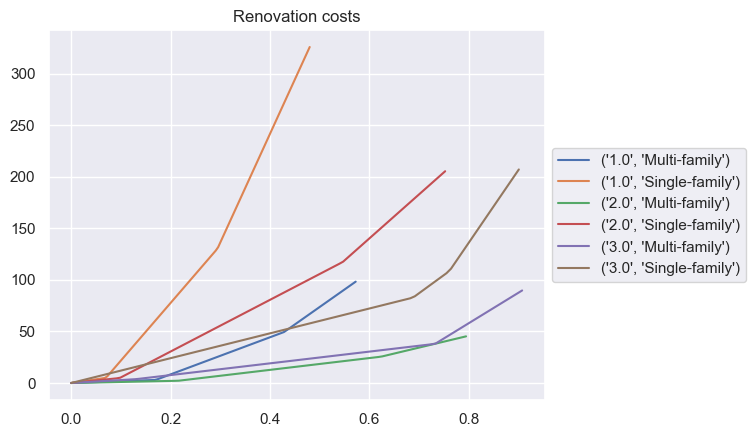

In [3]:
hourly_profile_test = heating_hourly_profile(method="valentin", percentage=0)

# TODO: attention au choix de hourly profile !!
# ['Occupancy status', 'Income owner', 'Income tenant', 'Housing type', 'Heating system']
dict_cost, dict_heat = social_planner(aggregation_archetype=['Wall class', "Housing type"], climate=2006, smooth=False, building_stock="medium_3",
                                      hourly_profile=hourly_profile_test)
dict_heat = process_heating_need(dict_heat, climate=2006)
linearized_renovation_costs, threshold_linearized_renovation_costs = piecewise_linearization_cost_efficiency(dict_cost, number_of_segments=3, plot=True, plot_tot=True)

threshold_linearized_renovation_costs[threshold_linearized_renovation_costs < 0] = 0  # handles cases where the linearization was not perfect

In [4]:
sum([(dict_heat[key]*1).sum() for key in dict_heat.keys()])

192018.42898243916

2022-11-28 12:16:24,559 - 38879 - log_ - INFO - Creating AgentBuildings object
2022-11-28 12:16:24,559 - 38879 - log_ - INFO - Creating AgentBuildings object


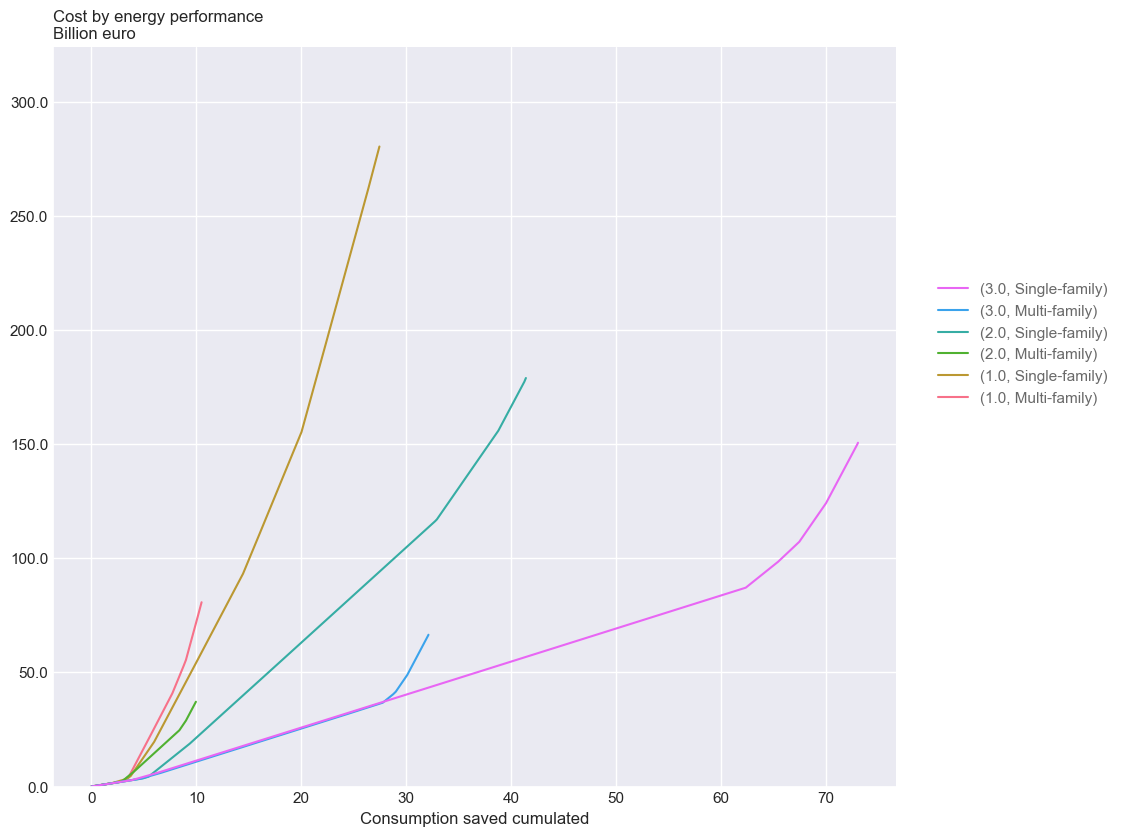

In [5]:
from project.utils import make_plots
dict_cost, dict_heat = social_planner(aggregation_archetype=['Wall class', 'Housing type'], climate=2006, smooth=False, building_stock="medium_3", percent=False)
make_plots(dict_cost, 'Cost by energy performance (Billion euro)', loc="left", left=1.15)

## Process generation output

In [25]:
tmp = m_scc.hourly_generation
climate = 2006
tmp["date"] = tmp.apply(lambda row: datetime.datetime(climate, 1, 1, 0) + datetime.timedelta(hours=row["hour"]), axis=1)
tmp = tmp.set_index("date")

In [36]:
h_start, h_end = 0, 60 # winter
# h_start, h_end = 2800, 3000 # spring
# h_start, h_end = 4300, 4500 # summer
# list_hour = tmp.index[h_start:h_end].to_list()
date_start, date_end = datetime.datetime(climate, 2, 15, 0), datetime.datetime(climate, 2, 17, 23)
list_time = tmp.index[(tmp.index > date_start) & (tmp.index < date_end)].to_list()

prod_label = ["offshore_f", "offshore_g", "onshore", "pv_g", "pv_c", "river", "lake", "nuclear", "methanization", "pyrogazification",
              "ocgt", "ccgt", "methanation", "electrolysis", "battery1", "battery4", "hydrogen", "methane", "phs"]
prod_label = ["offshore_f", "offshore_g", "onshore", "pv_g", "pv_c", "nuclear", "methanization", "pyrogazification", "ocgt", "ccgt"]
prod_label = ["offshore_f", "offshore_g", "onshore", "nuclear", "methanization", "pyrogazification", "ocgt", "ccgt", "methanation"]
# list_prod = [tmp[key].iloc[h_start:h_end].to_list() for key in prod_label]
list_prod = [tmp[key][list_time].to_list() for key in prod_label]

str_label = ["hydrogen", "methane", "hydrogen_in", "methane_in", "electrolysis"]
list_str = [tmp[key][list_time].to_list() for key in str_label]


methane_label = ["methane", "methane_in"]
list_methane = [tmp[key][list_time].to_list() for key in methane_label]

gas_label = ["methane", "methane_in", "methanization", "pyrogazification"]
list_gas = [tmp[key][list_time].to_list() for key in gas_label]

single_tec_label = ["electrolysis"]
list_single_tec = [tmp[key][list_time].to_list() for key in single_tec_label]



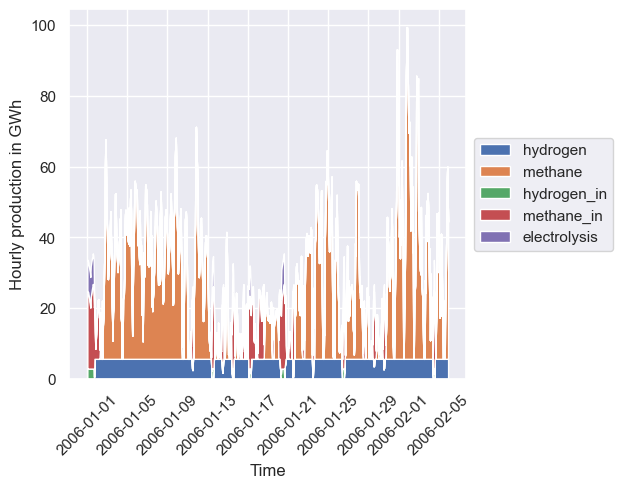

In [46]:
fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_time, list_str, labels=str_label)
ax.set_ylabel("Hourly production in GWh")
ax.set_xlabel("Time")
# ax.set_ylim(0,10)
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.set_facecolor('xkcd:white')
plt.xticks(rotation = 45)
plt.show()

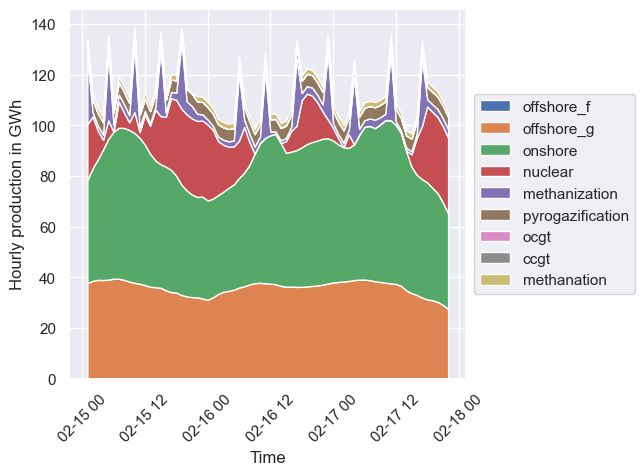

In [37]:
fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_time, list_prod, labels=prod_label)
ax.set_ylabel("Hourly production in GWh")
ax.set_xlabel("Time")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.set_facecolor('xkcd:white')
plt.xticks(rotation = 45)
plt.show()

In [13]:
list_methane[1]

[19.504193852530864,
 19.310528146210512,
 16.982929174480464,
 14.074685041457915,
 11.166440908435423,
 5.930597803680282,
 2.3622818239011742,
 0.0,
 4.957837541627761,
 10.00013225928534,
 17.176477561575464,
 20.49330699764909,
 21.07395215893909,
 21.145978703969938,
 19.270497774879285,
 18.087718923440704,
 8.583774649418036,
 1.0563962108442517,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.102829904838295,
 8.279878177996544,
 10.18077027991935,
 8.102425901397009,
 6.378216450793781,
 2.291691388141949,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.506035585056485,
 4.575407969507653,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.871290454944525,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 

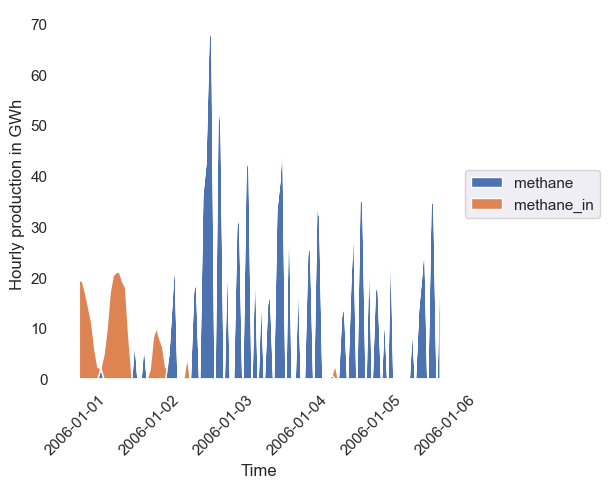

In [11]:
fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_time, list_methane, labels=methane_label)
ax.set_ylabel("Hourly production in GWh")
ax.set_xlabel("Time")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_facecolor('xkcd:white')
plt.xticks(rotation = 45)
plt.show()

In [369]:
list_single_tec

[[9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  4.697509106381841,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
 

In [34]:
tmp[["hydrogen", "hydrogen_in", "hydrogen_charge", "electrolysis"]]

hydrogen  hydrogen_in  hydrogen_charge  electrolysis
date                                                                     
2006-01-01 00:00:00       0.0     3.472742      7321.801839      9.180505
2006-01-01 01:00:00       0.0     3.472742      7325.274581      9.180505
2006-01-01 02:00:00       0.0     3.472742      7328.747323      9.180505
2006-01-01 03:00:00       0.0     3.472742      7332.220065      9.180505
2006-01-01 04:00:00       0.0     3.472742      7335.692807      9.180505
...                       ...          ...              ...           ...
2006-12-31 19:00:00       0.0     3.472742      7304.438129      9.180505
2006-12-31 20:00:00       0.0     3.472742      7307.910871      9.180505
2006-12-31 21:00:00       0.0     3.472742      7311.383613      9.180505
2006-12-31 22:00:00       0.0     3.472742      7314.856355      9.180505
2006-12-31 23:00:00       0.0     3.472742      7318.329097      9.180505

[8760 rows x 4 columns]

In [20]:
tmp[["heat_demand", "CH4_demand", "elec_demand", "methane", "methane_in", "methane_charge", "methanization", "pyrogazification", "methanation"]]

heat_demand  CH4_demand  elec_demand  methane  \
date                                                                 
2006-01-01 00:00:00    49.101582   14.129032    69.712739      0.0   
2006-01-01 01:00:00    54.713191   15.058065    65.166886      0.0   
2006-01-01 02:00:00    57.518995   15.522581    59.364789      0.0   
2006-01-01 03:00:00    58.921898   15.754839    56.803051      0.0   
2006-01-01 04:00:00    64.533507   16.683871    53.313940      0.0   
...                          ...         ...          ...      ...   
2006-12-31 19:00:00    39.539773   14.729032    71.801487      0.0   
2006-12-31 20:00:00    35.682234   13.877419    75.025726      0.0   
2006-12-31 21:00:00    32.789080   13.238710    74.135638      0.0   
2006-12-31 22:00:00    31.824695   13.025806    70.753361      0.0   
2006-12-31 23:00:00    40.504158   14.941935    67.272580      0.0   

                     methane_in  methane_charge  methanization  \
date                                                             
2006-01-01 00:00:00   31.053853    14101.202260      34.209394   
2006-01-01 01:00:00   30.124820    14132.256113      34.209394   
2006-01-01 02:00:00   29.660304    14162.380933      34.209394   
2006-01-01 03:00:00   29.428046    14192.041238      34.209394   
2006-01-01 04:00:00   28.499014    14221.469284      34.209394   
...                         ...             ...            ...   
2006-12-31 19:00:00   30.453853    13945.100739      34.209394   
2006-12-31 20:00:00   31.305466    13975.554591      34.209394   
2006-12-31 21:00:00   31.944175    14006.860057      34.209394   
2006-12-31 22:00:00   32.157079    14038.804232      34.209394   
2006-12-31 23:00:00   30.240949    14070.961311      34.209394   

                     pyrogazification  methanation  
date                                                
2006-01-01 00:00:00          7.990868     2.982624  
2006-01-01 01:00:00          7.990868     2.982624  
2006-01-01 02:00:00          7.990868     2.982624  
2006-01-01 03:00:00          7.990868     2.982624  
2006-01-01 04:00:00          7.990868     2.982624  
...                               ...          ...  
2006-12-31 19:00:00          7.990868     2.982624  
2006-12-31 20:00:00          7.990868     2.982624  
2006-12-31 21:00:00          7.990868     2.982624  
2006-12-31 22:00:00          7.990868     2.982624  
2006-12-31 23:00:00          7.990868     2.982624  

[8760 rows x 9 columns]

In [30]:
tmp[["heat_demand", "CH4_demand", "elec_demand", "methane", "methane_in", "methane_charge", "methanization", "pyrogazification", "methanation"]]

heat_demand  CH4_demand  elec_demand  methane  \
date                                                                 
2006-01-01 00:00:00    58.029142           0    69.712739      0.0   
2006-01-01 01:00:00    64.661044           1    65.166886      0.0   
2006-01-01 02:00:00    67.976995           2    59.364789      0.0   
2006-01-01 03:00:00    69.634970           3    56.803051      0.0   
2006-01-01 04:00:00    76.266872           4    53.313940      0.0   
...                          ...         ...          ...      ...   
2006-12-31 19:00:00    46.728823        8755    71.801487      0.0   
2006-12-31 20:00:00    42.169913        8756    75.025726      0.0   
2006-12-31 21:00:00    38.750731        8757    74.135638      0.0   
2006-12-31 22:00:00    37.611004        8758    70.753361      0.0   
2006-12-31 23:00:00    47.868550        8759    67.272580      0.0   

                     methane_in  methane_charge  methanization  \
date                                                             
2006-01-01 00:00:00         0.0             0.0       7.683871   
2006-01-01 01:00:00         0.0             0.0       8.612903   
2006-01-01 02:00:00         0.0             0.0       9.077419   
2006-01-01 03:00:00         0.0             0.0       9.309677   
2006-01-01 04:00:00         0.0             0.0      15.062244   
...                         ...             ...            ...   
2006-12-31 19:00:00         0.0             0.0       8.283871   
2006-12-31 20:00:00         0.0             0.0       7.432258   
2006-12-31 21:00:00         0.0             0.0       6.793548   
2006-12-31 22:00:00         0.0             0.0       6.580645   
2006-12-31 23:00:00         0.0             0.0       8.496774   

                     pyrogazification  methanation  
date                                                
2006-01-01 00:00:00          3.305333     3.139829  
2006-01-01 01:00:00          3.305333     3.139829  
2006-01-01 02:00:00          3.305333     3.139829  
2006-01-01 03:00:00          3.305333     3.139829  
2006-01-01 04:00:00          3.305333     3.139829  
...                               ...          ...  
2006-12-31 19:00:00          3.305333     3.139829  
2006-12-31 20:00:00          3.305333     3.139829  
2006-12-31 21:00:00          3.305333     3.139829  
2006-12-31 22:00:00          3.305333     3.139829  
2006-12-31 23:00:00          3.305333     3.139829  

[8760 rows x 9 columns]

In [15]:
tmp[["elec_demand", "battery1", "battery4", "phs", "battery1_in", "battery4_in", "phs_in"]]

elec_demand  battery1  battery4  phs  battery1_in  \
date                                                                     
2006-01-01 00:00:00    69.712739  0.000000  6.839157  0.0          0.0   
2006-01-01 01:00:00    65.166886  0.000000  6.160698  0.0          0.0   
2006-01-01 02:00:00    59.364789  0.000000  2.664485  0.0          0.0   
2006-01-01 03:00:00    56.803051  0.305741  1.314967  0.0          0.0   
2006-01-01 04:00:00    53.313940  0.000000  0.305752  0.0          0.0   
...                          ...       ...       ...  ...          ...   
2006-12-31 19:00:00    71.801487  0.000000  0.000000  0.0          0.0   
2006-12-31 20:00:00    75.025726  0.000000  0.000000  0.0          0.0   
2006-12-31 21:00:00    74.135638  0.000000  0.000000  0.0          0.0   
2006-12-31 22:00:00    70.753361  0.000000  0.000000  0.0          0.0   
2006-12-31 23:00:00    67.272580  0.000000  0.000000  0.0          0.0   

                     battery4_in    phs_in  
date                                        
2006-01-01 00:00:00      0.00000  0.000000  
2006-01-01 01:00:00      0.00000  0.000000  
2006-01-01 02:00:00      0.00000  0.000000  
2006-01-01 03:00:00      0.00000  0.000000  
2006-01-01 04:00:00      0.00000  0.000000  
...                          ...       ...  
2006-12-31 19:00:00      0.00000  0.000000  
2006-12-31 20:00:00      0.00000  0.000000  
2006-12-31 21:00:00      0.00000  0.000000  
2006-12-31 22:00:00      0.00000  6.778221  
2006-12-31 23:00:00      1.80174  7.200000  

[8760 rows x 7 columns]

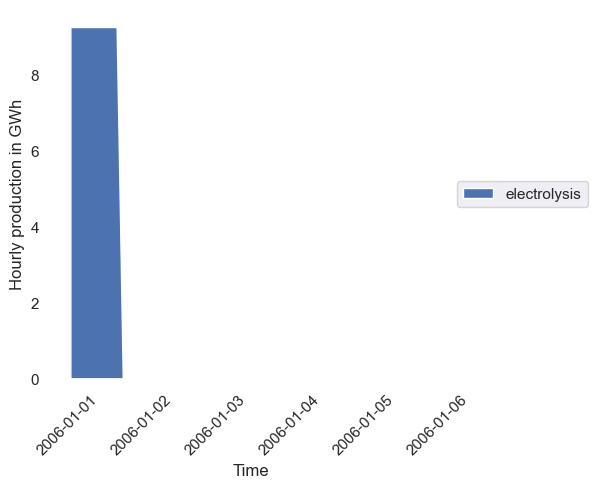

In [368]:
fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_time, list_single_tec, labels=single_tec_label)
ax.set_ylabel("Hourly production in GWh")
ax.set_xlabel("Time")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_facecolor('xkcd:white')
plt.xticks(rotation = 45)
plt.show()

# Run model

In [4]:
# Historical data for LCOE calculus

existing_capacity_historical, existing_charging_capacity_historical, existing_energy_capacity_historical,\
           maximum_capacity_evolution, heating_gas_demand_RTE_timesteps, ECS_gas_demand_RTE_timesteps, annuity_fOM_historical, storage_annuity_historical = load_evolution_data()

existing_capa_historical_y = existing_capacity_historical[[str(2050)]].squeeze()  # get historical capacity still installed for year of interest
existing_charging_capacity_historical_y = existing_charging_capacity_historical[[str(2050)]].squeeze()
existing_energy_capacity_historical_y = existing_energy_capacity_historical[[str(2050)]].squeeze()

annualized_costs_capacity_historical, annualized_costs_energy_capacity_historical = annualized_costs_investment_historical(existing_capa_historical_y, annuity_fOM_historical,
                           existing_energy_capacity_historical_y, storage_annuity_historical)

existing_annualized_costs_elec, existing_annualized_costs_CH4, existing_annualized_costs_H2 = process_annualized_costs_per_vector(annualized_costs_capacity_historical[["annualized_costs"]].squeeze(), annualized_costs_energy_capacity_historical[["annualized_costs"]].squeeze())


In [17]:
list_scc = [0, 100, 200, 300, 400, 500]
list_social_cost = []
list_technical_cost = []
list_emissions = []
list_primary_production = []
list_heat_generation = []
reindex_primary_prod = ["offshore_f", "offshore_g", "onshore", "pv_g", "pv_c", "river", "lake", "nuclear", "methanization", "pyrogazification", "natural_gas"]
reindex_heat_prod = ["resistive", "heat_pump", "gas_boiler", "fuel_boiler", "wood_boiler"]

capacity_df = pd.DataFrame(index=existing_capacity_historical.index, dtype=float)
generation_df = pd.DataFrame(index=existing_capacity_historical.index, dtype=float)
primary_generation_df = pd.DataFrame(index=reindex_primary_prod, dtype=float)
heat_generation_df = pd.DataFrame(index=reindex_heat_prod, dtype=float)
renovation_rate_df = pd.DataFrame(index=list(dict_heat.keys()), dtype=float)

# TODO: attention, a changer !!
dict_heat_modif = {key: dict_heat[key]*1.1 for key in dict_heat.keys()}  # TODO: a enlever, permet de voir l'impact d'augmenter le besoin en chaleur

# we add hourly heat profile
hourly_gas = create_hourly_residential_demand_profile(total_consumption=24*1e3, method="valentin")  # value for gas heating demand in tertiary sector
hourly_ECS = pd.Series(2.5, index=hourly_gas.index)  # may include industry as well (if just tertiary + residential ECS, we get a total of 22TWh per year, or 2.5GWh per hour)
# hourly_ECS = pd.Series(13, index=hourly_gas.index)  # may include industry as well (if just tertiary + residential ECS, we get a total of 22TWh per year, or 2.5GWh per hour)
hourly_CH4_gas = hourly_gas + hourly_ECS

scenario_cost_high = {
    "capex": {
        # "heat_pump": 1050,  # change back to actual level of price
        "gas_boiler": 300,  # hypothesis Zeyen
        "fuel_boiler": 300,  # hypothesis Zeyen
        "wood_boiler": 300,  # hypothesis Zeyen
        # "nuclear": 4500,  # change back to 5500
        # "onshore": 900,
        # "methanation": 1500  # trying a method similar to zeyen
    } ,
    "fOM": {
        "gas_boiler": 21  # hypothesis Zeyen
    } ,
    "vOM": {
        "heat_pump": 0.002,  # hypothesis Zeyen
        # "natural_gas": 0.032
    },
    "conversion_efficiency": {
        "gas_boiler": 0.95,
        # "methanation": 0.5  # trying a method similar to zeyen
    },
    "miscellaneous": {
        # "max_methanization": 50,
        # "max_pyrogazification": 50,
        "lifetime_renov": 40
    },
    # "biomass_potential": {
    #     "methanization": 50,
    #     "pyrogazification": 0
    # },
    "maximum_capacity": {
        "nuclear": 30,
        "offshore_f": 40,  # initially 20
        "offshore_g": 20,  # initially 40
        # "phs": 8
    },
    "fix_capa": {
        "h2_ccgt": 0,
        # "nuclear": 0
        # "methane": 0,  # we test when we do not allow for hydrogen/methane storage
        # "hydrogen": 0,
        # "battery1": 0,
        # "battery4": 0,
        # "methanation": 4,
        # "pyrogazification": 0,
        # "methanization": 0
    }
}  # we increase prices to check the impact on the output

for scc in list_scc:
    print(f"Social cost of carbon: {scc}")
    m_scc = ModelEOLES(name="test", config=config, path="eoles/outputs", logger=logger, nb_years=1, heating_demand=dict_heat_modif, nb_linearize=3,
                       linearized_renovation_costs=linearized_renovation_costs, threshold_linearized_renovation_costs=threshold_linearized_renovation_costs,
                       social_cost_of_carbon=scc, year=2050, scenario_cost=scenario_cost_high, hp_hourly=True, renov=None,
                       hourly_heat_gas=hourly_CH4_gas, existing_annualized_costs_elec=existing_annualized_costs_elec,
                       existing_annualized_costs_CH4=existing_annualized_costs_CH4, existing_annualized_costs_H2=existing_annualized_costs_H2)
    m_scc.build_model()
    solver_results, status, termination_condition = m_scc.solve(solver_name="gurobi")

    list_social_cost.append(m_scc.objective)
    list_technical_cost.append(m_scc.technical_cost)
    list_emissions.append(m_scc.emissions)

    list_primary_production.append(m_scc.primary_generation.reindex(reindex_primary_prod).to_list())
    list_heat_generation.append(m_scc.heat_generation.reindex(reindex_heat_prod).to_list())

    gene_per_tec = pd.Series(m_scc.generation_per_technology)
    capacity_df = pd.concat([capacity_df, m_scc.capacities.to_frame().rename(columns={0: scc})], axis=1)
    generation_df = pd.concat([generation_df, gene_per_tec.to_frame().rename(columns={0: scc})], axis=1)
    renovation_rate_df = pd.concat([renovation_rate_df, m_scc.renovation_rates.to_frame().rename(columns={0: scc})], axis=1)
    primary_generation_df = pd.concat([primary_generation_df, m_scc.primary_generation.reindex(reindex_primary_prod).to_frame().rename(columns={0: scc})], axis=1)
    heat_generation_df = pd.concat([heat_generation_df, m_scc.heat_generation.reindex(reindex_heat_prod).to_frame().rename(columns={0: scc})], axis=1)

Social cost of carbon: 0


2022-12-23 16:42:02,953 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-12-23 16:42:29,915 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:349: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:364: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (


23733.46036446902 12629.183187437604 1056.3303574292654
Social cost of carbon: 100


2022-12-23 16:42:45,746 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-12-23 16:43:25,883 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:349: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:364: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (


31948.171262832668 11896.10528325315 1188.6830882992683
Social cost of carbon: 200


2022-12-23 16:43:41,883 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-12-23 16:44:17,330 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:349: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:364: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (


34119.3118001888 12681.205000384945 1318.6260256794567
Social cost of carbon: 300


2022-12-23 16:44:33,223 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-12-23 16:45:18,342 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:349: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:364: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (


36434.92809570433 11422.482096103233 1578.3426012153627
Social cost of carbon: 400


2022-12-23 16:45:34,213 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-12-23 16:46:25,341 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:349: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:364: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (


38189.96771685764 10460.529238502899 1496.278701092547
Social cost of carbon: 500


2022-12-23 16:46:41,042 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-12-23 16:47:33,325 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:349: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:364: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (


38335.50683209637 9398.463346417251 1434.00435013394


In [7]:
m_scc.spot_price.describe()

hour    spot_price
count  8760.000000   8760.000000
mean   4379.500000     57.562727
std    2528.938512    602.307569
min       0.000000     -0.000000
25%    2189.750000      6.000000
50%    4379.500000     12.105814
75%    6569.250000     81.088219
max    8759.000000  55860.547585

In [28]:
m_scc.summary

weighted_elec_price_demand     62.305929
weighted_CH4_price_demand      71.474124
weighted_H2_price_demand       40.409409
weighted_price_generation      49.713398
elec_demand_tot               561.970000
hydrogen_demand_tot            50.000000
methane_demand_tot             45.900000
heat_demand_tot               211.220272
sumgene_elec                  757.021934
lcoe_elec                      55.386341
lcoe_elec_volume               54.628868
lcoe_CH4_volume                18.137226
lcoe_H2_volume                 81.530931
lcoe_elec_value                73.460206
lcoe_CH4_value                147.062385
lcoe_H2_value                  38.616526
dtype: float64

In [5]:
m_scc.summary

weighted_elec_price_demand     62.307328
weighted_CH4_price_demand      71.472196
weighted_H2_price_demand       40.414263
weighted_price_generation      49.714997
elec_demand_tot               561.970000
hydrogen_demand_tot            50.000000
methane_demand_tot             45.900000
heat_demand_tot               211.220272
sumgene_elec                  757.004766
lcoe_elec                      50.906626
lcoe_elec_volume               60.032908
lcoe_CH4_volume               189.813281
lcoe_H2_volume                 82.437556
lcoe_elec_value                67.557104
lcoe_CH4_value                146.501088
lcoe_H2_value                  37.630696
dtype: float64

In [23]:
m_scc.summary

weighted_elec_price_demand     62.305929
weighted_CH4_price_demand      71.474124
weighted_H2_price_demand       52.546834
weighted_price_generation      49.713408
elec_demand_tot               561.970000
hydrogen_demand_tot            50.000000
methane_demand_tot             45.900000
heat_demand_tot               211.220272
sumgene_elec                  757.019407
lcoe_elec                      50.905027
lcoe_elec_volume               60.031992
lcoe_CH4_volume               189.833543
lcoe_H2_volume                 82.434235
lcoe_elec_value                67.556247
lcoe_CH4_value                146.521692
lcoe_H2_value                  37.626404
dtype: float64

# Post-processing

## Model output

In [18]:
m_scc.capacities

offshore_f            0.000000
offshore_g           36.000000
onshore              80.000000
pv_g                 67.900000
pv_c                  0.000000
river                 7.500000
lake                 12.855000
methanization        50.914169
ocgt                 30.316846
ccgt                 16.804138
nuclear              30.000000
h2_ccgt               0.000000
phs                   7.200000
battery1              0.000000
battery4              0.000000
methanation           4.718950
pyrogazification      0.000000
electrolysis         10.701891
natural_gas           0.000000
hydrogen              5.707763
methane             113.675795
heat_pump            37.988277
gas_boiler           36.565073
resistive            13.683832
fuel_boiler           3.477487
wood_boiler           0.000000
dtype: float64

In [24]:
m_scc.capacities

offshore_f            0.000000
offshore_g           36.000000
onshore              80.000000
pv_g                 67.936816
pv_c                  0.000000
river                 7.500000
lake                 12.855000
methanization        50.915510
ocgt                 30.330699
ccgt                 16.789321
nuclear              30.000000
h2_ccgt               0.000000
phs                   7.200000
battery1              0.000000
battery4              0.000000
methanation           4.718635
pyrogazification      0.000000
electrolysis         10.699026
natural_gas           0.000000
hydrogen              5.707763
methane             113.690062
heat_pump            37.983238
gas_boiler           36.570301
resistive            13.692146
fuel_boiler           3.477332
wood_boiler           0.000000
dtype: float64

In [6]:
m_scc.objective

51.928107970062335

In [128]:
H2_spot_price = [1e6 * m_scc.model.dual[m_scc.model.methane_balance_constraint[h]] for h in m_scc.model.h]

In [130]:
np.std(H2_spot_price)

7.8422711620413486

In [28]:
m_scc.lcoe_per_tec

{'offshore_f': nan,
 'offshore_g': 37.42157167119368,
 'onshore': 29.08773814012567,
 'pv_g': 26.682669110770068,
 'pv_c': nan,
 'river': 43.50947140653866,
 'lake': 54.00642398372334,
 'nuclear': 66.69384329049429,
 'ocgt': 1051.1571908847,
 'ccgt': 277.1260490009553,
 'h2_ccgt': nan,
 'methanization': 82.66477295790807,
 'pyrogazification': nan}

In [33]:
m_scc.storage_annuities

0
battery1    24.278262
battery4    14.281330
phs          1.194211
hydrogen     0.069679
methane      0.061392
Name: 1, dtype: float64

In [30]:
m_scc.generation_per_technology

{'offshore_f': 0.0,
 'offshore_g': 165.69527657176758,
 'onshore': 227.55635575911973,
 'pv_g': 96.60588533509323,
 'pv_c': 0.0,
 'river': 28.48260030787517,
 'lake': 15.30218636999985,
 'methanization': 105.99999999999905,
 'ocgt': 2.268999339891493,
 'ccgt': 15.404857196939883,
 'nuclear': 205.7032460796725,
 'h2_ccgt': 0.0,
 'phs': 15.67048196904942,
 'battery1': 0.0,
 'battery4': 0.0,
 'methanation': 27.347999999997327,
 'pyrogazification': 0.0,
 'electrolysis': 49.99999999999855,
 'natural_gas': 0.0,
 'hydrogen': 19.61780193944213,
 'methane': 22.08325574731242,
 'heat_pump': 143.41518566287053,
 'gas_boiler': 41.06207729436483,
 'resistive': 9.037398604245904,
 'fuel_boiler': 0.06637603296864644,
 'wood_boiler': 0.0}

## Graphs

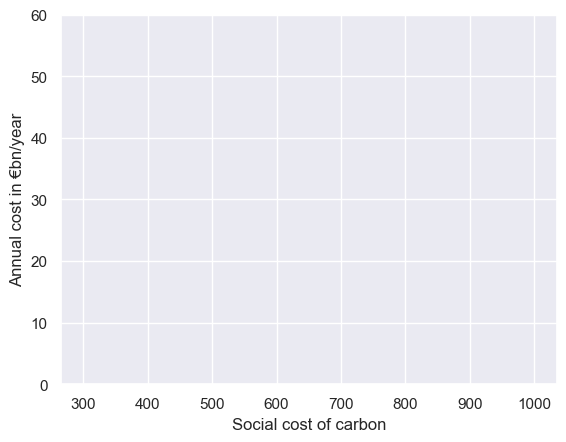

In [75]:
plt.plot(list_scc, list_social_cost)
plt.ylim(0, 60)
plt.ylabel("Annual cost in €bn/year")
plt.xlabel("Social cost of carbon")
plt.show()

In [8]:
m_scc.summary

weighted_price_demand           70.864314
weighted_price_generation       66.541615
elec_demand_tot                561.970000
hydrogen_demand_tot              0.050000
methane_demand_tot              70.560000
heat_demand_tot                192.018429
offshore_f                       0.000000
offshore_g                      92.052931
onshore                        227.556356
pv_g                           120.643922
pv_c                             0.000000
river                           28.482600
lake                            15.302186
methanization                   30.000000
ocgt                             1.392751
ccgt                             1.761506
nuclear                        208.820529
h2_ccgt                         29.758709
phs                             15.765215
battery1                         0.396137
battery4                         2.346426
methanation                      7.740000
pyrogazification                70.000000
electrolysis                    52

In [20]:
m_scc.capacities

offshore_f            0.000000
offshore_g           40.000000
onshore              80.000000
pv_g                 84.240429
pv_c                  0.000000
river                 7.500000
lake                 12.855000
methanization        26.434989
ocgt                 27.059682
ccgt                 20.998027
nuclear              26.004576
h2_ccgt               0.000000
phs                   7.200000
battery1              1.299728
battery4              5.339861
methanation           2.085625
pyrogazification      5.645831
electrolysis          9.253144
natural_gas           0.000000
hydrogen              5.707763
methane             119.802235
heat_pump            43.257254
gas_boiler           27.371815
resistive            12.910243
fuel_boiler           0.000000
wood_boiler           0.000000
dtype: float64

### Capacity

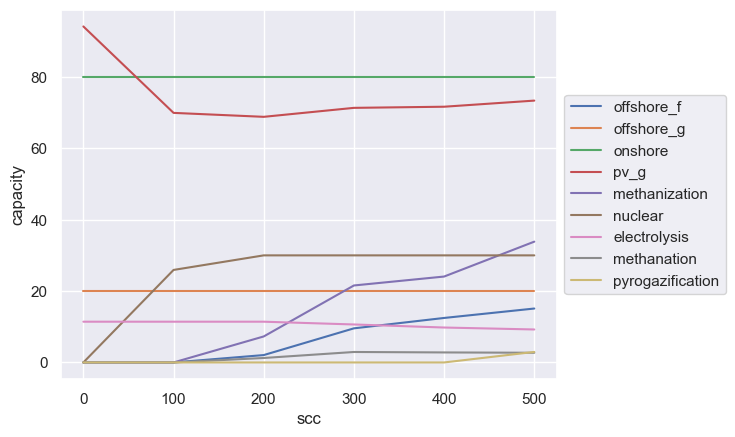

In [6]:
tmp = capacity_df.transpose().stack().reset_index().rename(columns={'level_0': 'scc', 'level_1': 'technology', 0: 'capacity'})
tmp = tmp.loc[tmp.technology.isin(["offshore_f", "offshore_g", "onshore", "pv_g", "methanization", "nuclear", "electrolysis", "methanation", "pyrogazification"])]
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(tmp, x="scc", y="capacity", hue="technology")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

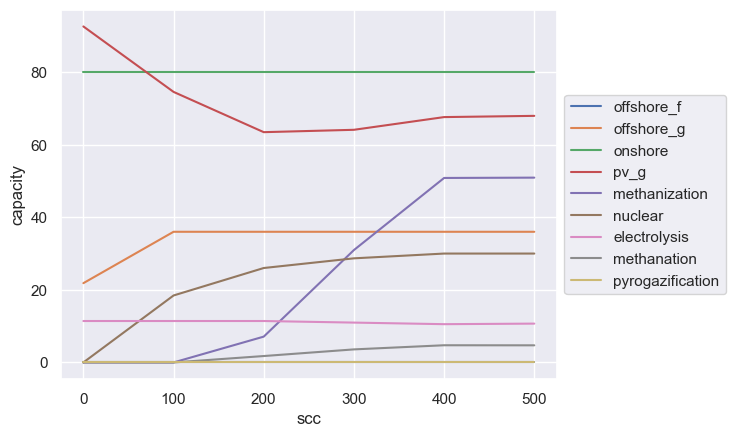

In [20]:
tmp = capacity_df.transpose().stack().reset_index().rename(columns={'level_0': 'scc', 'level_1': 'technology', 0: 'capacity'})
tmp = tmp.loc[tmp.technology.isin(["offshore_f", "offshore_g", "onshore", "pv_g", "methanization", "nuclear", "electrolysis", "methanation", "pyrogazification"])]
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(tmp, x="scc", y="capacity", hue="technology")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Primary production

<Figure size 640x480 with 0 Axes>

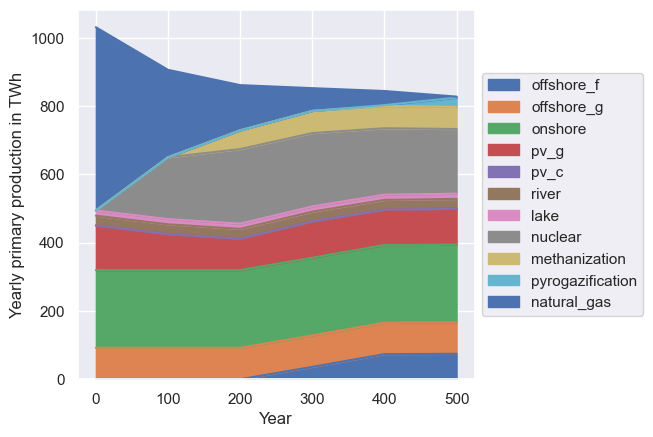

In [19]:
fig = plt.figure()
ax = primary_generation_df.T.plot.area()
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Year")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

<Figure size 640x480 with 0 Axes>

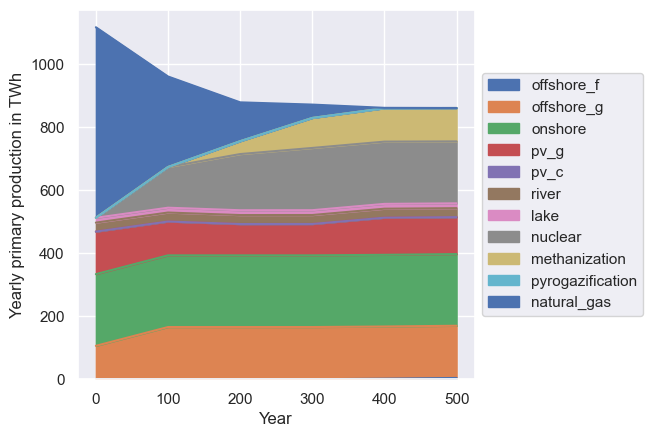

In [15]:
fig = plt.figure()
ax = primary_generation_df.T.plot.area()
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Year")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

<Figure size 640x480 with 0 Axes>

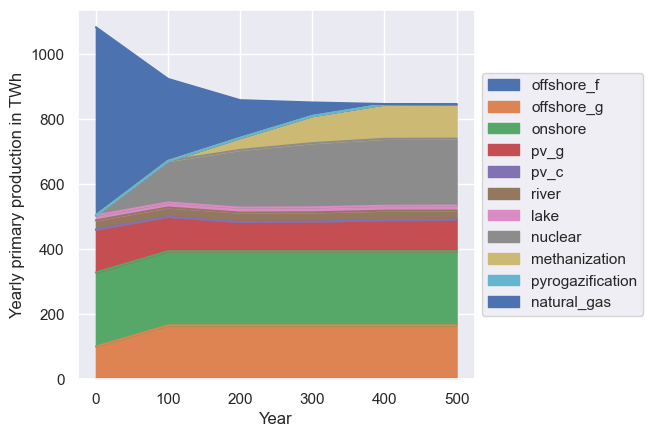

In [21]:
fig = plt.figure()
ax = primary_generation_df.T.plot.area()
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Year")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

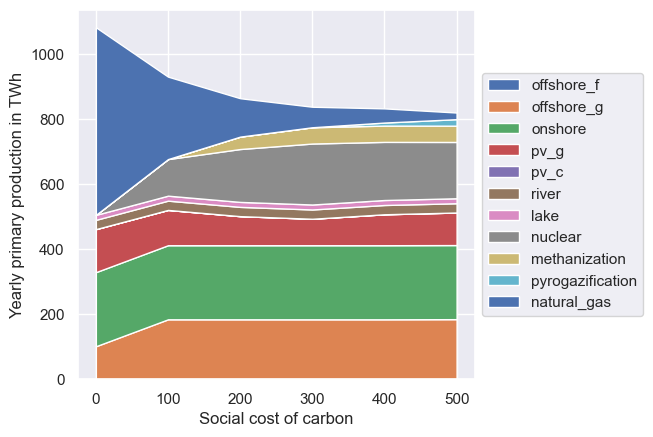

In [25]:
list_primary_production_transpose = np.transpose(np.array(list_primary_production)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_primary_production_transpose, labels=reindex_primary_prod)
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

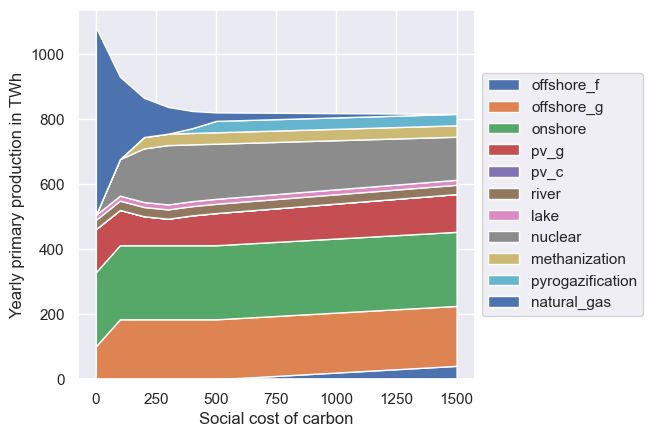

In [26]:
list_primary_production_transpose = np.transpose(np.array(list_primary_production)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_primary_production_transpose, labels=reindex_primary_prod)
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

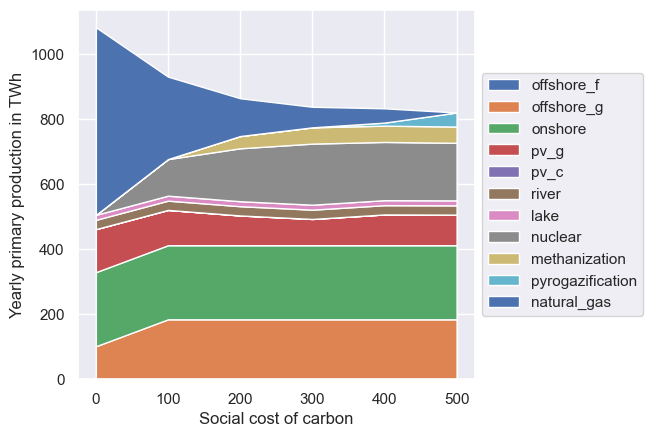

In [21]:
list_primary_production_transpose = np.transpose(np.array(list_primary_production)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_primary_production_transpose, labels=reindex_primary_prod)
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

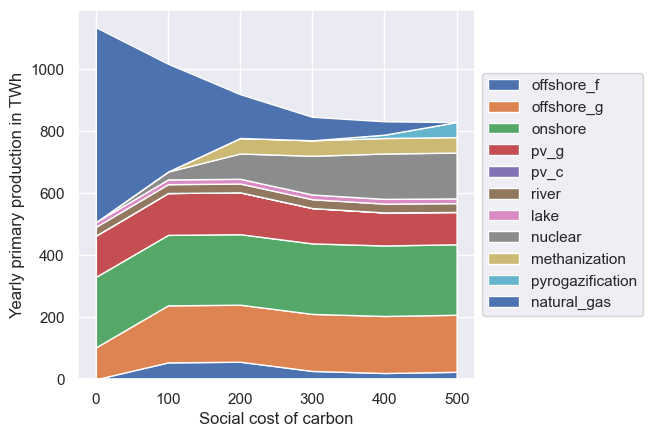

In [10]:
list_primary_production_transpose = np.transpose(np.array(list_primary_production)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_primary_production_transpose, labels=reindex_primary_prod)
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

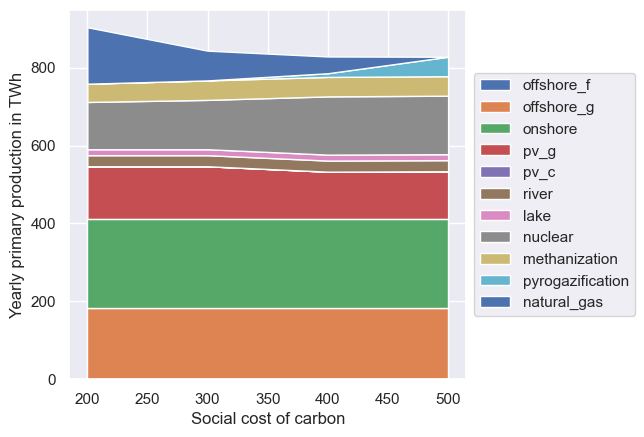

In [6]:
list_primary_production_transpose = np.transpose(np.array(list_primary_production)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_primary_production_transpose, labels=reindex_primary_prod)
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

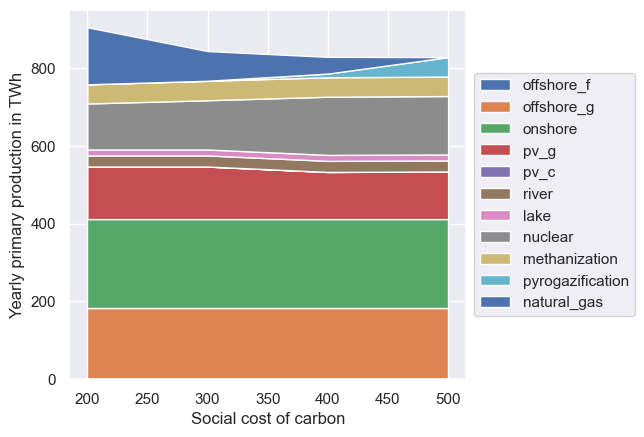

In [163]:
list_primary_production_transpose = np.transpose(np.array(list_primary_production)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_primary_production_transpose, labels=reindex_primary_prod)
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Production

<Figure size 640x480 with 0 Axes>

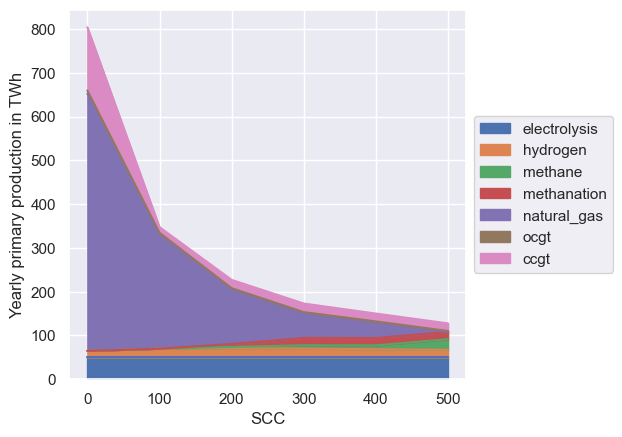

In [9]:
fig = plt.figure()
ax = generation_df.T[["electrolysis", "hydrogen", "methane", "methanation", "natural_gas", "ocgt", "ccgt"]].plot.area()
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("SCC")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

<Figure size 640x480 with 0 Axes>

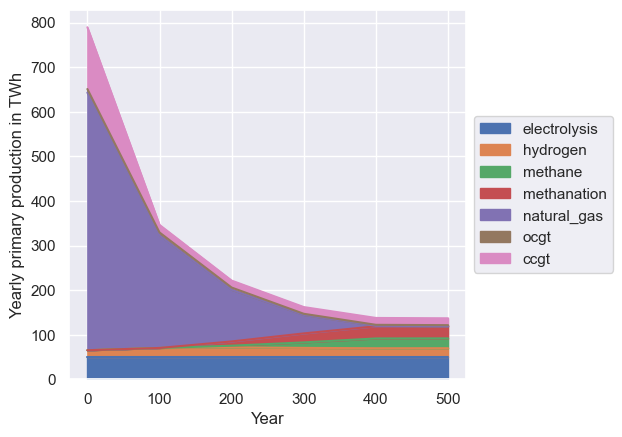

In [26]:
fig = plt.figure()
ax = generation_df.T[["electrolysis", "hydrogen", "methane", "methanation", "natural_gas", "ocgt", "ccgt"]].plot.area()
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Year")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Heat production

<Figure size 640x480 with 0 Axes>

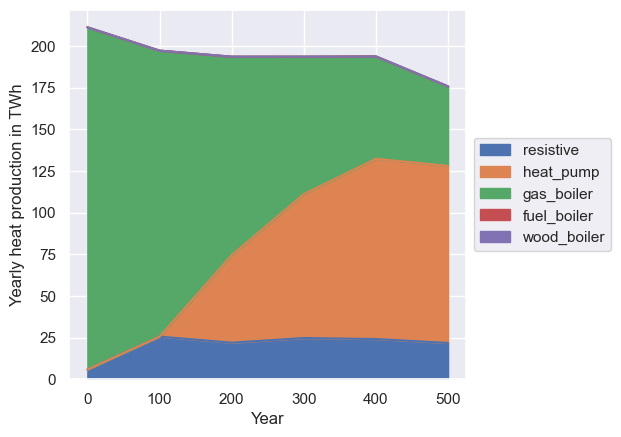

In [18]:
fig = plt.figure()
ax = heat_generation_df.T.plot.area()
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Year")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

<Figure size 640x480 with 0 Axes>

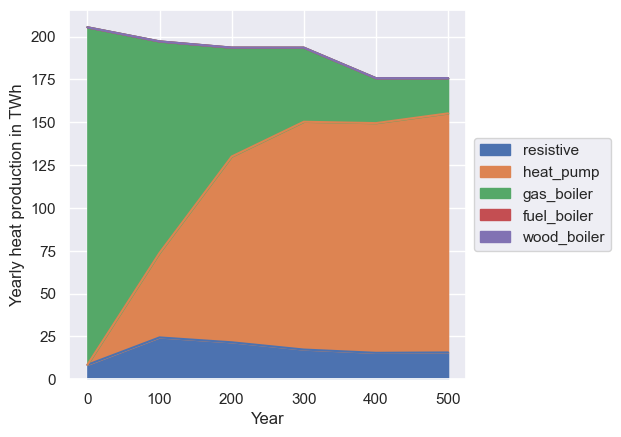

In [33]:
fig = plt.figure()
ax = heat_generation_df.T.plot.area()
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Year")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

<Figure size 640x480 with 0 Axes>

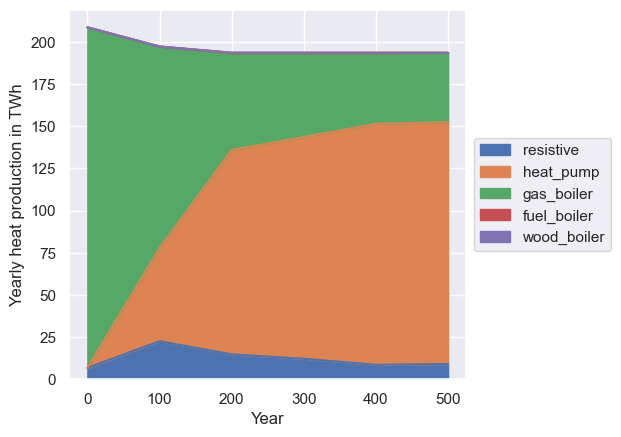

In [27]:
fig = plt.figure()
ax = heat_generation_df.T.plot.area()
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Year")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

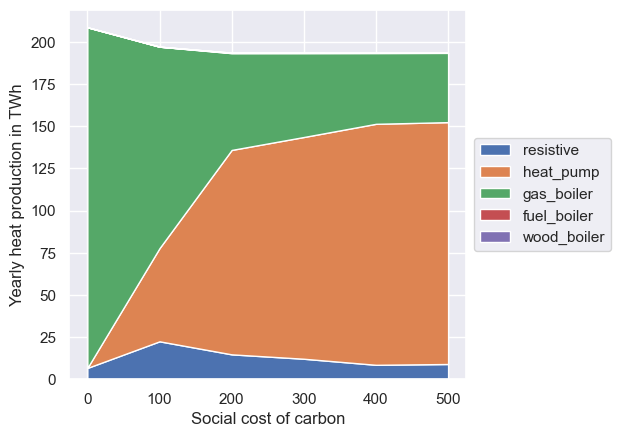

In [32]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

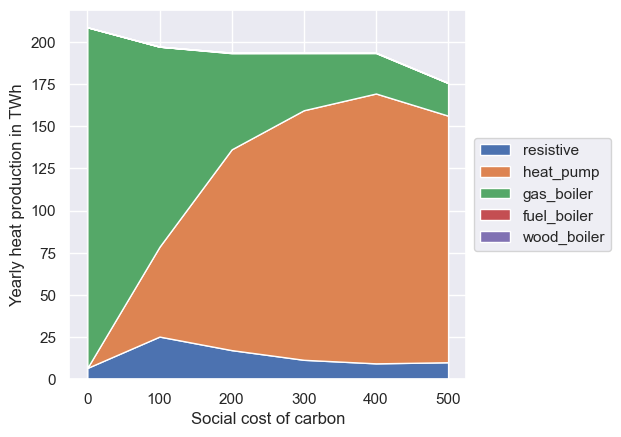

In [43]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

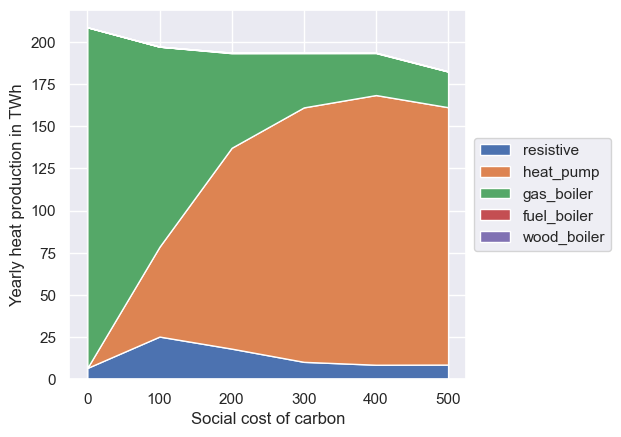

In [23]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

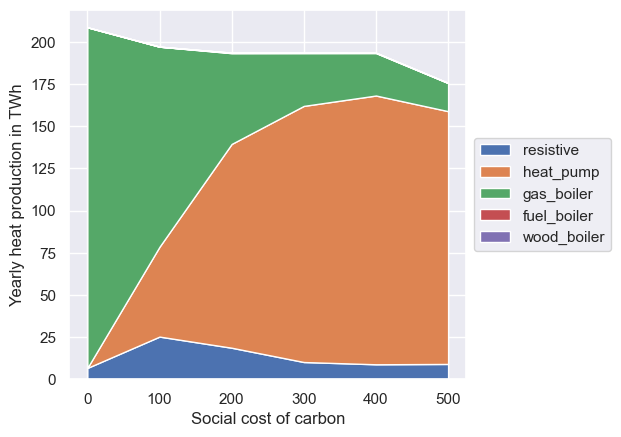

In [19]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

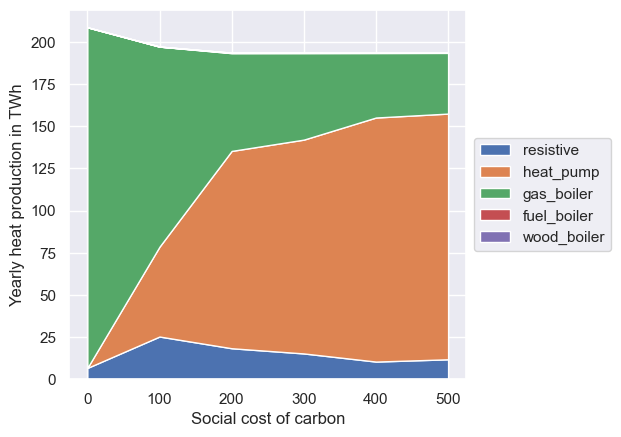

In [15]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

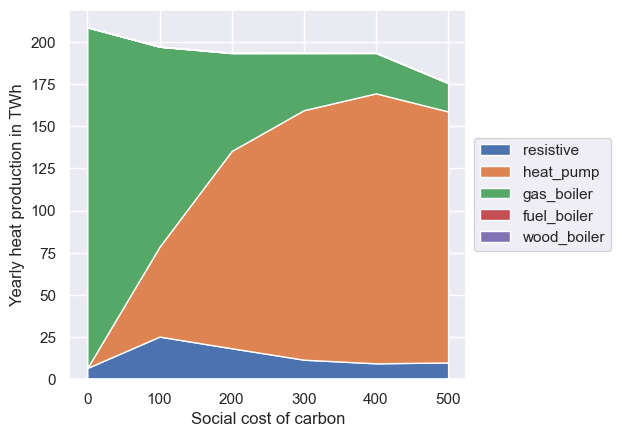

In [11]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

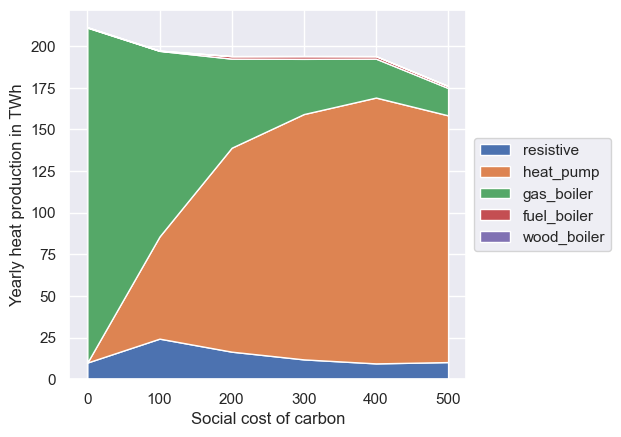

In [6]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

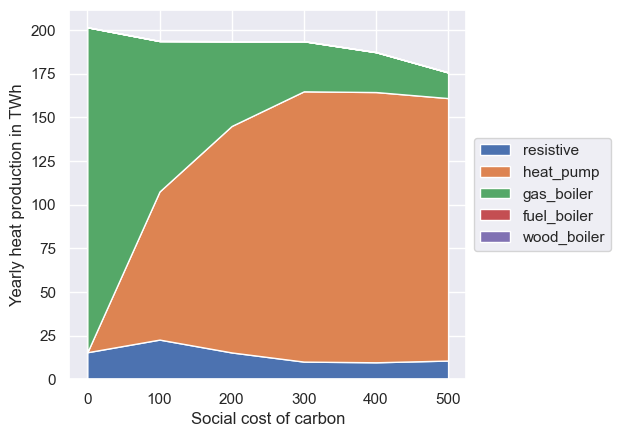

In [41]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

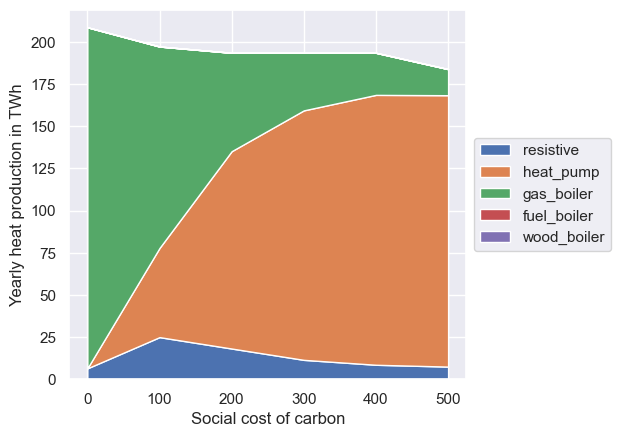

In [38]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

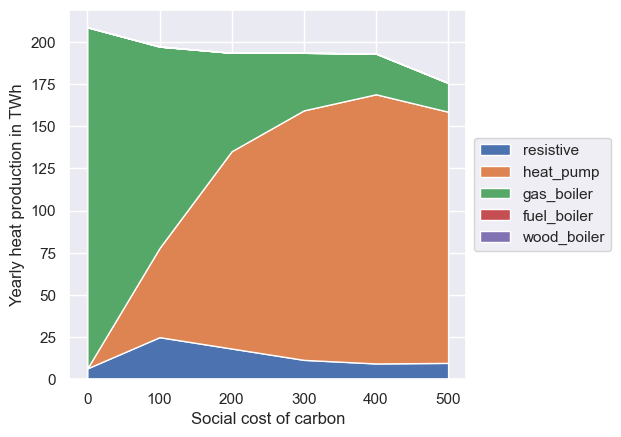

In [26]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

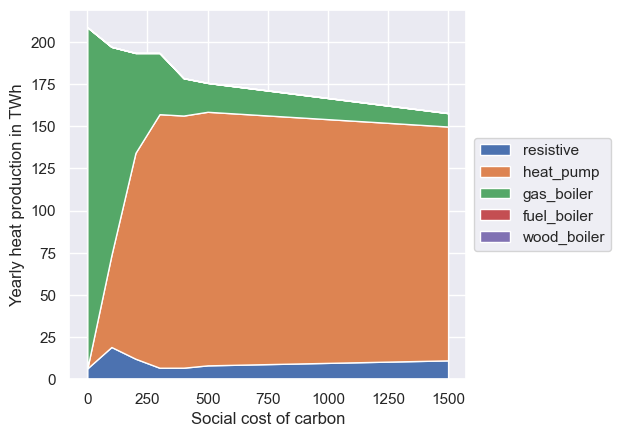

In [65]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

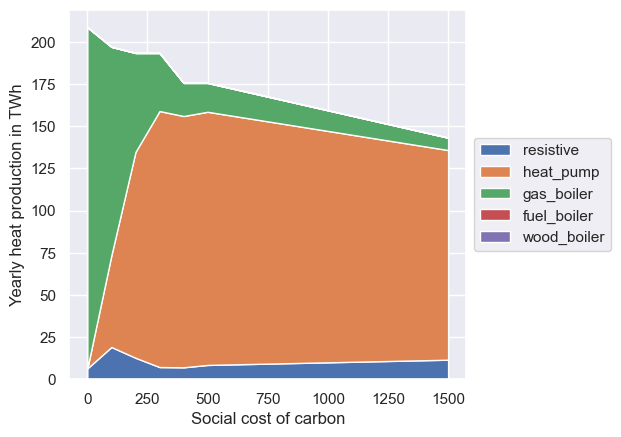

In [31]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

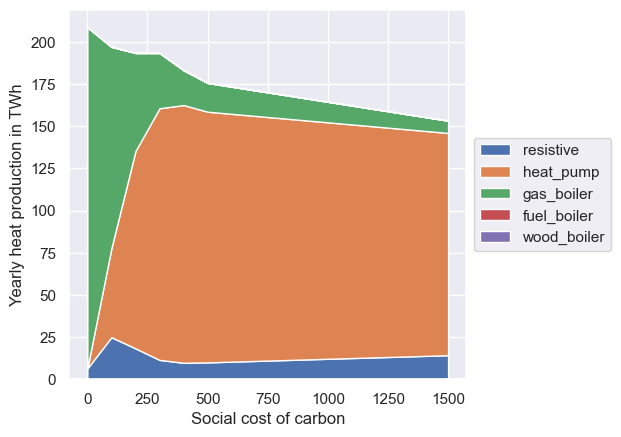

In [25]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

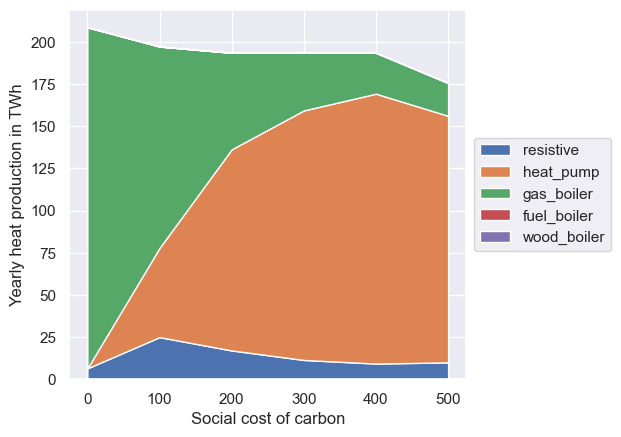

In [22]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

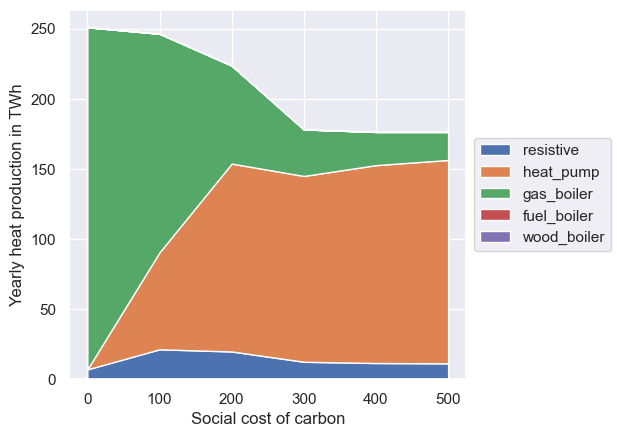

In [11]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

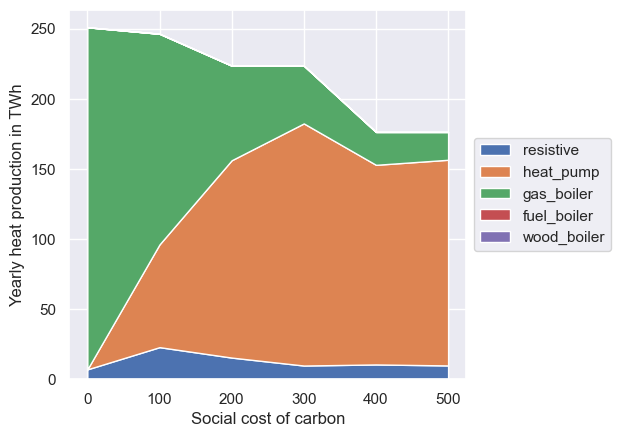

In [7]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

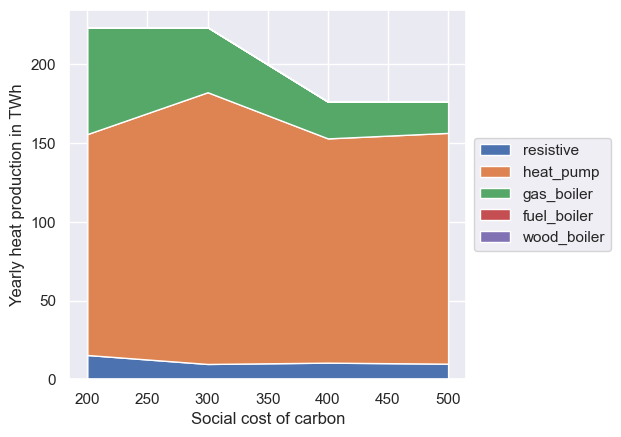

In [28]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

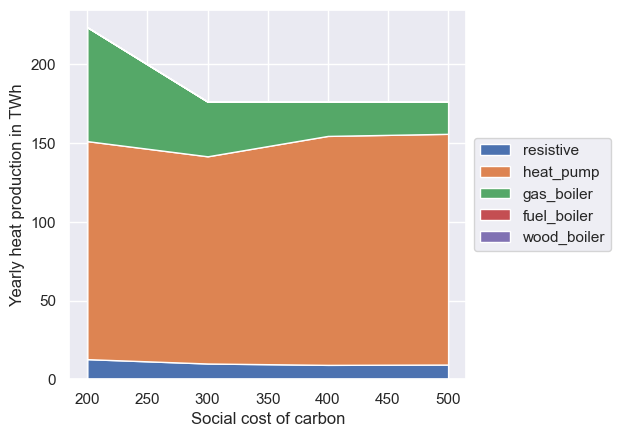

In [24]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

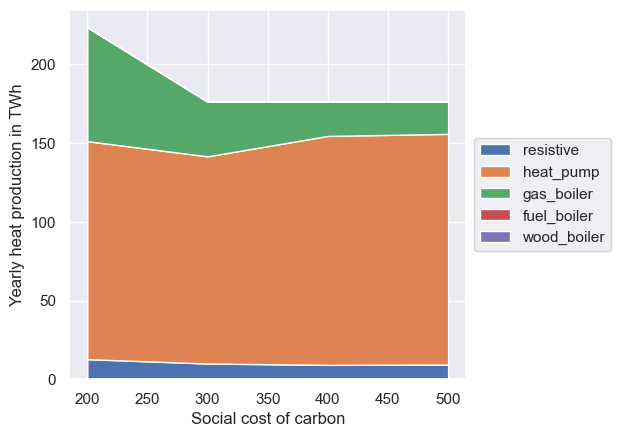

In [6]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

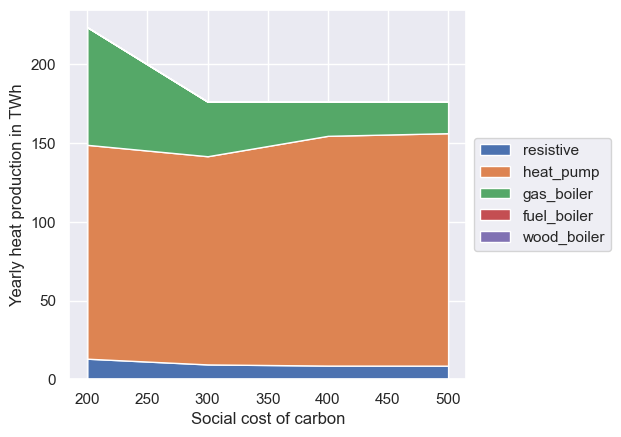

In [7]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

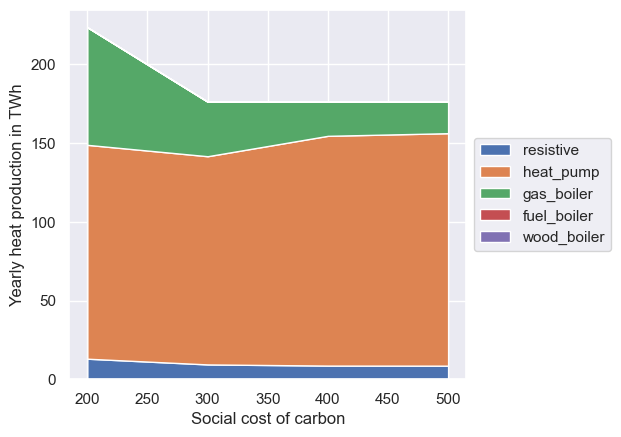

In [164]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [78]:
renovation_rate_df

1.0                        2.0                        3.0  \
  Multi-family Single-family Multi-family Single-family Multi-family   
0     0.000000      0.000000     0.000000      0.000000     0.000000   
1     0.170003      0.000000     0.215394      0.000000     0.131225   
2     0.170003      0.000000     0.215394      0.097347     0.131225   
3     0.170003      0.070006     0.215394      0.097347     0.131225   
4     0.170003      0.070006     0.215394      0.097347     0.131225   
5     0.170003      0.070006     0.215394      0.097347     0.131225   

                 
  Single-family  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
5           0.0

## Renovation

In [11]:
renovation_rate_df_plot = renovation_rate_df.transpose().stack().reset_index().rename(columns={'level_0': 'scc', 'level_1': 'archetype', 0: 'renovation_rate'})
renovation_rate_df_plot

scc             archetype  renovation_rate
0     0   (1.0, Multi-family)         0.000000
1     0  (1.0, Single-family)         0.000000
2     0   (2.0, Multi-family)         0.215413
3     0  (2.0, Single-family)         0.000000
4     0   (3.0, Multi-family)         0.000000
5     0  (3.0, Single-family)         0.000000
6   100   (1.0, Multi-family)         0.169990
7   100  (1.0, Single-family)         0.000000
8   100   (2.0, Multi-family)         0.215413
9   100  (2.0, Single-family)         0.097346
10  100   (3.0, Multi-family)         0.131034
11  100  (3.0, Single-family)         0.000000
12  200   (1.0, Multi-family)         0.169990
13  200  (1.0, Single-family)         0.070004
14  200   (2.0, Multi-family)         0.215413
15  200  (2.0, Single-family)         0.097346
16  200   (3.0, Multi-family)         0.131034
17  200  (3.0, Single-family)         0.000000
18  300   (1.0, Multi-family)         0.169990
19  300  (1.0, Single-family)         0.070004
20  300   (2.0, Multi-family)         0.215413
21  300  (2.0, Single-family)         0.097346
22  300   (3.0, Multi-family)         0.131034
23  300  (3.0, Single-family)         0.000000
24  400   (1.0, Multi-family)         0.169990
25  400  (1.0, Single-family)         0.070004
26  400   (2.0, Multi-family)         0.215413
27  400  (2.0, Single-family)         0.097346
28  400   (3.0, Multi-family)         0.622008
29  400  (3.0, Single-family)         0.000000
30  500   (1.0, Multi-family)         0.169990
31  500  (1.0, Single-family)         0.070004
32  500   (2.0, Multi-family)         0.215413
33  500  (2.0, Single-family)         0.097346
34  500   (3.0, Multi-family)         0.732040
35  500  (3.0, Single-family)         0.000000

In [12]:
df_heat = pd.Series({key: dict_heat_modif[key].sum() for key in list(dict_heat_modif.keys())}).to_frame().rename(columns={0: "heat_demand"})
df_heat.index = df_heat.index.to_flat_index()
df_heat = df_heat.transpose().stack().reset_index().drop(columns=["level_0"]).rename(columns={'level_1': 'archetype', 0: "heat_demand"})
df_heat

archetype   heat_demand
0   (1.0, Multi-family)  19130.761858
1  (1.0, Single-family)  52012.334347
2   (2.0, Multi-family)  11683.958581
3  (2.0, Single-family)  44663.712122
4   (3.0, Multi-family)  29718.915104
5  (3.0, Single-family)  54010.589870

In [13]:
heat_and_renov = pd.merge(renovation_rate_df_plot.groupby(["archetype", "scc"])["renovation_rate"].sum().reset_index(), df_heat.groupby("archetype")["heat_demand"].sum().reset_index(),
         on='archetype')
heat_and_renov

archetype  scc  renovation_rate   heat_demand
0    (1.0, Multi-family)    0         0.000000  19130.761858
1    (1.0, Multi-family)  100         0.169990  19130.761858
2    (1.0, Multi-family)  200         0.169990  19130.761858
3    (1.0, Multi-family)  300         0.169990  19130.761858
4    (1.0, Multi-family)  400         0.169990  19130.761858
5    (1.0, Multi-family)  500         0.169990  19130.761858
6   (1.0, Single-family)    0         0.000000  52012.334347
7   (1.0, Single-family)  100         0.000000  52012.334347
8   (1.0, Single-family)  200         0.070004  52012.334347
9   (1.0, Single-family)  300         0.070004  52012.334347
10  (1.0, Single-family)  400         0.070004  52012.334347
11  (1.0, Single-family)  500         0.070004  52012.334347
12   (2.0, Multi-family)    0         0.215413  11683.958581
13   (2.0, Multi-family)  100         0.215413  11683.958581
14   (2.0, Multi-family)  200         0.215413  11683.958581
15   (2.0, Multi-family)  300         0.215413  11683.958581
16   (2.0, Multi-family)  400         0.215413  11683.958581
17   (2.0, Multi-family)  500         0.215413  11683.958581
18  (2.0, Single-family)    0         0.000000  44663.712122
19  (2.0, Single-family)  100         0.097346  44663.712122
20  (2.0, Single-family)  200         0.097346  44663.712122
21  (2.0, Single-family)  300         0.097346  44663.712122
22  (2.0, Single-family)  400         0.097346  44663.712122
23  (2.0, Single-family)  500         0.097346  44663.712122
24   (3.0, Multi-family)    0         0.000000  29718.915104
25   (3.0, Multi-family)  100         0.131034  29718.915104
26   (3.0, Multi-family)  200         0.131034  29718.915104
27   (3.0, Multi-family)  300         0.131034  29718.915104
28   (3.0, Multi-family)  400         0.622008  29718.915104
29   (3.0, Multi-family)  500         0.732040  29718.915104
30  (3.0, Single-family)    0         0.000000  54010.589870
31  (3.0, Single-family)  100         0.000000  54010.589870
32  (3.0, Single-family)  200         0.000000  54010.589870
33  (3.0, Single-family)  300         0.000000  54010.589870
34  (3.0, Single-family)  400         0.000000  54010.589870
35  (3.0, Single-family)  500         0.000000  54010.589870

In [14]:
heat = {}
for n, g in heat_and_renov.groupby('scc'):
    heat.update({n: g["heat_demand"].sum()})
heat

{0: 211220.27188068302,
 100: 211220.27188068302,
 200: 211220.27188068302,
 300: 211220.27188068302,
 400: 211220.27188068302,
 500: 211220.27188068302}

In [15]:
renov = {}
for n, g in heat_and_renov.groupby('scc'):
    renov.update({n: (g["renovation_rate"] * g["heat_demand"]).sum() / g["heat_demand"].sum()})

renov

{0: 0.011915904367341721,
 100: 0.06633343186859093,
 200: 0.08357177749127223,
 300: 0.08357177749127223,
 400: 0.15265235058369023,
 500: 0.1681339247984255}

In [39]:
renov = {}
for n, g in heat_and_renov.groupby('scc'):
    renov.update({n: (g["renovation_rate"] * g["heat_demand"]).sum() / g["heat_demand"].sum()})

renov

{0: 0.027311863771996514,
 100: 0.06634877340116321,
 200: 0.08358697981808459,
 300: 0.08358697981808459,
 400: 0.1681337804941641,
 500: 0.1681337804941641}

In [149]:
renovation_rate_df_plot.sort_values(by="renovation_rate", ascending=False)

scc level_1        level_2  renovation_rate          archetype
22  500     3.0   Multi-family         0.732041   3.0 Multi-family
4   200     3.0   Multi-family         0.732041   3.0 Multi-family
16  400     3.0   Multi-family         0.732041   3.0 Multi-family
10  300     3.0   Multi-family         0.732041   3.0 Multi-family
23  500     3.0  Single-family         0.687660  3.0 Single-family
17  400     3.0  Single-family         0.687660  3.0 Single-family
11  300     3.0  Single-family         0.687660  3.0 Single-family
14  400     2.0   Multi-family         0.215400   2.0 Multi-family
2   200     2.0   Multi-family         0.215400   2.0 Multi-family
20  500     2.0   Multi-family         0.215400   2.0 Multi-family
8   300     2.0   Multi-family         0.215400   2.0 Multi-family
18  500     1.0   Multi-family         0.169996   1.0 Multi-family
0   200     1.0   Multi-family         0.169996   1.0 Multi-family
6   300     1.0   Multi-family         0.169996   1.0 Multi-family
12  400     1.0   Multi-family         0.169996   1.0 Multi-family
15  400     2.0  Single-family         0.097350  2.0 Single-family
9   300     2.0  Single-family         0.097350  2.0 Single-family
21  500     2.0  Single-family         0.097350  2.0 Single-family
3   200     2.0  Single-family         0.097350  2.0 Single-family
13  400     1.0  Single-family         0.070005  1.0 Single-family
1   200     1.0  Single-family         0.070005  1.0 Single-family
7   300     1.0  Single-family         0.070005  1.0 Single-family
19  500     1.0  Single-family         0.070005  1.0 Single-family
5   200     3.0  Single-family         0.000000  3.0 Single-family

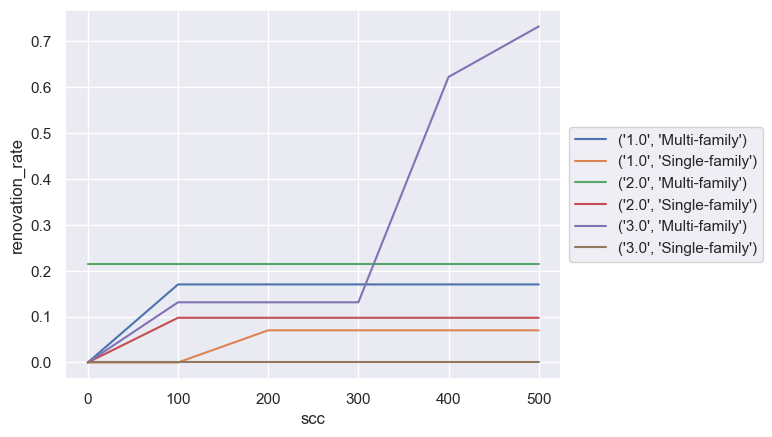

In [16]:
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(renovation_rate_df_plot, x="scc", y="renovation_rate", hue="archetype")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

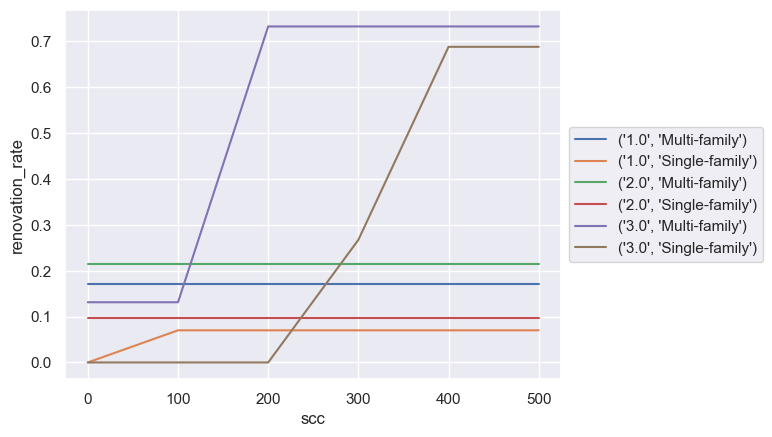

In [54]:
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(renovation_rate_df_plot, x="scc", y="renovation_rate", hue="archetype")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

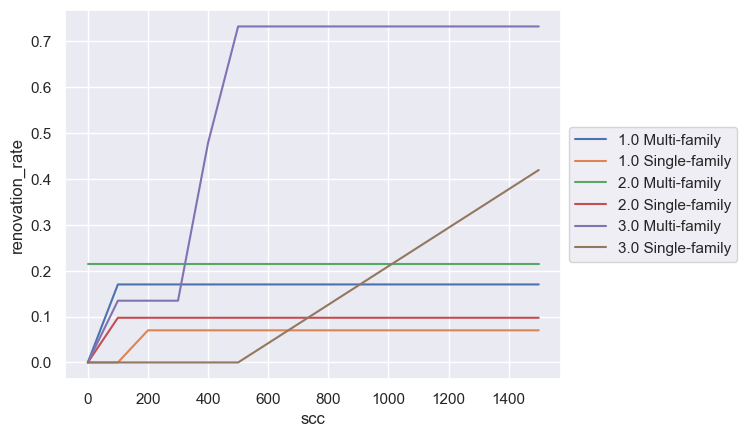

In [24]:
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(renovation_rate_df_plot, x="scc", y="renovation_rate", hue="archetype")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

<AxesSubplot:xlabel='scc', ylabel='renovation_rate'>

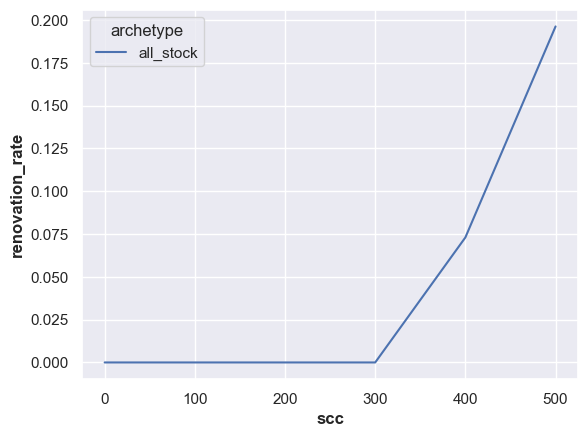

In [48]:
sns.lineplot(renovation_rate_df, x="scc", y="renovation_rate", hue="archetype")

## Process weather data

### Process weather data

In [117]:
from pathlib import Path
from eoles.utils import get_pandas
path_weather = Path("eoles") / "inputs" / "ninja_weather_country_FR_merra-2_population_weighted.csv"
weather = get_pandas(path_weather,
           lambda x: pd.read_csv(x, header=2))
weather["date"] = weather.apply(lambda row: datetime.datetime.strptime(row["time"], '%Y-%m-%d %H:%M:%S'), axis=1)
weather = weather.loc[(weather.date >= datetime.datetime(climate, 1, 1, 0)) & (weather.date <= datetime.datetime(climate, 12, 31, 23))]
weather["day"] = weather.apply(lambda row: row["date"].date(), axis=1)

weather_daily = weather.groupby("day")["temperature"].mean().reset_index().rename(columns={"temperature": "daily_temperature"})

weather = pd.merge(weather, weather_daily, on=["day"])

load_factors = m_scc.load_factors.reset_index().rename(columns={0: "technology", 1: "hour", 2: "capacity_factor"})
load_factors["date"] = load_factors.apply(lambda row: datetime.datetime(climate, 1, 1, 0) + datetime.timedelta(hours=row["hour"]), axis=1)

weather = pd.merge(weather, load_factors.drop(columns=["hour"]), on=["date"])

In [96]:
weather

time  precipitation  temperature  irradiance_surface  \
0      2006-01-01 00:00:00          0.240        3.083                 0.0   
1      2006-01-01 00:00:00          0.240        3.083                 0.0   
2      2006-01-01 00:00:00          0.240        3.083                 0.0   
3      2006-01-01 00:00:00          0.240        3.083                 0.0   
4      2006-01-01 00:00:00          0.240        3.083                 0.0   
...                    ...            ...          ...                 ...   
52555  2006-12-31 23:00:00          0.574       10.358                 0.0   
52556  2006-12-31 23:00:00          0.574       10.358                 0.0   
52557  2006-12-31 23:00:00          0.574       10.358                 0.0   
52558  2006-12-31 23:00:00          0.574       10.358                 0.0   
52559  2006-12-31 23:00:00          0.574       10.358                 0.0   

       irradiance_toa  snowfall  snow_mass  cloud_cover  air_density  \
0                 0.0    0.0288     2.5060       0.8610       1.2265   
1                 0.0    0.0288     2.5060       0.8610       1.2265   
2                 0.0    0.0288     2.5060       0.8610       1.2265   
3                 0.0    0.0288     2.5060       0.8610       1.2265   
4                 0.0    0.0288     2.5060       0.8610       1.2265   
...               ...       ...        ...          ...          ...   
52555             0.0    0.0000     0.0345       0.9614       1.2175   
52556             0.0    0.0000     0.0345       0.9614       1.2175   
52557             0.0    0.0000     0.0345       0.9614       1.2175   
52558             0.0    0.0000     0.0345       0.9614       1.2175   
52559             0.0    0.0000     0.0345       0.9614       1.2175   

                     date         day  daily_temperature  technology  \
0     2006-01-01 00:00:00  2006-01-01           3.870000  offshore_f   
1     2006-01-01 00:00:00  2006-01-01           3.870000  offshore_g   
2     2006-01-01 00:00:00  2006-01-01           3.870000     onshore   
3     2006-01-01 00:00:00  2006-01-01           3.870000        pv_g   
4     2006-01-01 00:00:00  2006-01-01           3.870000        pv_c   
...                   ...         ...                ...         ...   
52555 2006-12-31 23:00:00  2006-12-31           8.016542  offshore_g   
52556 2006-12-31 23:00:00  2006-12-31           8.016542     onshore   
52557 2006-12-31 23:00:00  2006-12-31           8.016542        pv_g   
52558 2006-12-31 23:00:00  2006-12-31           8.016542        pv_c   
52559 2006-12-31 23:00:00  2006-12-31           8.016542       river   

       capacity_factor  
0             0.936250  
1             0.865143  
2             0.511702  
3             0.000000  
4             0.000000  
...                ...  
52555         0.988143  
52556         0.818481  
52557         0.000000  
52558         0.000000  
52559         0.181049  

[52560 rows x 14 columns]

In [118]:
# Plot evolution of heating need and temperature
climate = 2006
df_heat_plot = df_heat.rename(columns={"date": "hour"})  # we use previously defined df_heat
df_heat_plot["date"] = df_heat_plot.apply(lambda row: datetime.datetime(climate, 1, 1, 0) + datetime.timedelta(hours=row["hour"]), axis=1)
df_heat_plot = df_heat_plot.groupby("date")["heat_demand"].sum().reset_index()

date_start, date_end = datetime.datetime(climate, 1, 16, 0), datetime.datetime(climate, 2, 28, 23)
# list_time = df_heat_plot.index[(df_heat_plot.index > date_start) & (df_heat_plot.index < date_end)].to_list()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


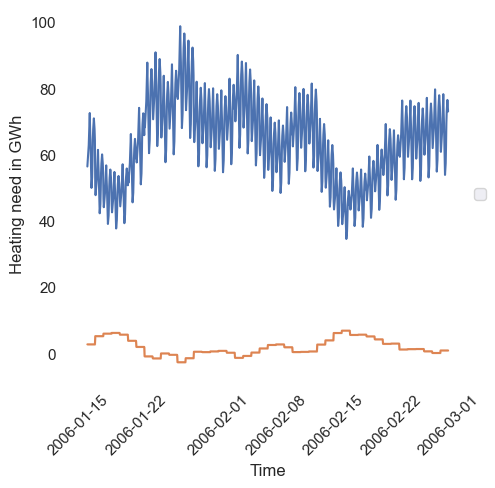

In [119]:
fig = plt.figure()
ax = plt.subplot(111)
# sns.lineplot(df_heat_plot.loc[(df_heat_plot.date > date_start) & (df_heat_plot.date < date_end)], x="date", y="heat_demand", hue="archetype")
sns.lineplot(df_heat_plot.loc[(df_heat_plot.date > date_start) & (df_heat_plot.date < date_end)], x="date", y="heat_demand")  # plot heating need
sns.lineplot(weather.loc[(weather.date > date_start) & (weather.date < date_end)], x="date", y="daily_temperature")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_facecolor('xkcd:white')
plt.xticks(rotation = 45)
ax.set_ylabel("Heating need in GWh")
ax.set_xlabel("Time")

# ax2 = ax.twinx()  # add other axis for weather data
# sns.lineplot(weather.loc[(weather.date > date_start) & (weather.date < date_end) & (weather.technology.isin(["offshore_f", "onshore"]))], x="date", y="capacity_factor",
#              hue="technology", ax=ax2)

# ax.set_ylim(0,10)
# Shrink current axis by 20%

plt.show()

### Smooth heating profile

In [120]:
dict_cost_smooth, dict_heat_smooth = social_planner(aggregation_archetype=['Wall class', 'Housing type'], climate=2006, smooth=True, building_stock="medium_3",
                                      hourly_profile=hourly_profile_test)
dict_heat_smooth = process_heating_need(dict_heat_smooth, climate=2006)
dict_heat_modif_smooth = {key: dict_heat_smooth[key]*1.1 for key in dict_heat_smooth.keys()}  # TODO: a enlever, permet de voir l'impact d'augmenter le besoin en chaleur

df_heat_smooth = pd.DataFrame(dict_heat_modif_smooth).stack(
    level=[i for i in range(pd.DataFrame(dict_heat_modif_smooth).columns.nlevels)]).reset_index()
df_heat_smooth["archetype"] = df_heat_smooth.apply(lambda row: row["level_1"] + ' ' + row["level_2"], axis=1)  # should be changed depending on level of multiindex
# df_heat["archetype"] = df_heat.apply(lambda row: row["level_1"], axis=1)  # should be changed depending on level of multiindex
df_heat_smooth = df_heat_smooth.rename(columns={"level_0": "date", 0: "heat_demand"})

# Plot evolution of heating need and temperature

climate = 2006
df_heat_smooth = df_heat_smooth.rename(columns={"date": "hour"})
df_heat_smooth["date"] = df_heat_smooth.apply(lambda row: datetime.datetime(climate, 1, 1, 0) + datetime.timedelta(hours=row["hour"]), axis=1)
df_heat_smooth = df_heat_smooth.groupby("date")["heat_demand"].sum().reset_index()


2022-12-05 14:22:58,256 - 75961 - log_ - INFO - Creating AgentBuildings object
2022-12-05 14:22:58,256 - 75961 - log_ - INFO - Creating AgentBuildings object
2022-12-05 14:22:58,256 - 75961 - log_ - INFO - Creating AgentBuildings object
2022-12-05 14:22:58,256 - 75961 - log_ - INFO - Creating AgentBuildings object
2022-12-05 14:22:58,256 - 75961 - log_ - INFO - Creating AgentBuildings object


In [124]:
df_heat_plot.sum()

/var/folders/1c/f0py8khj3bx759_g1q03n6fc0000gn/T/ipykernel_75961/3837886878.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_heat_plot.sum()


heat_demand    211220.271881
dtype: float64

In [123]:
df_heat_smooth.sum()

/var/folders/1c/f0py8khj3bx759_g1q03n6fc0000gn/T/ipykernel_75961/4253487980.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_heat_smooth.sum()


heat_demand    210788.270868
dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


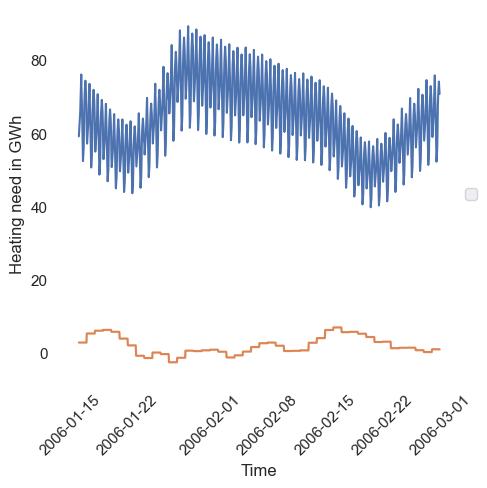

In [121]:
date_start, date_end = datetime.datetime(climate, 1, 16, 0), datetime.datetime(climate, 2, 28, 23)
# list_time = df_heat_plot.index[(df_heat_plot.index > date_start) & (df_heat_plot.index < date_end)].to_list()

fig = plt.figure()
ax = plt.subplot(111)
# sns.lineplot(df_heat_plot.loc[(df_heat_plot.date > date_start) & (df_heat_plot.date < date_end)], x="date", y="heat_demand", hue="archetype")
sns.lineplot(df_heat_smooth.loc[(df_heat_smooth.date > date_start) & (df_heat_smooth.date < date_end)], x="date", y="heat_demand")  # plot heating need
sns.lineplot(weather.loc[(weather.date > date_start) & (weather.date < date_end)], x="date", y="daily_temperature")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_facecolor('xkcd:white')
plt.xticks(rotation = 45)
ax.set_ylabel("Heating need in GWh")
ax.set_xlabel("Time")

plt.show()

# Social planner trajectory

## Load data

2022-12-23 16:56:14,233 - 45575 - log_ - INFO - Creating AgentBuildings object
2022-12-23 16:56:14,233 - 45575 - log_ - INFO - Creating AgentBuildings object


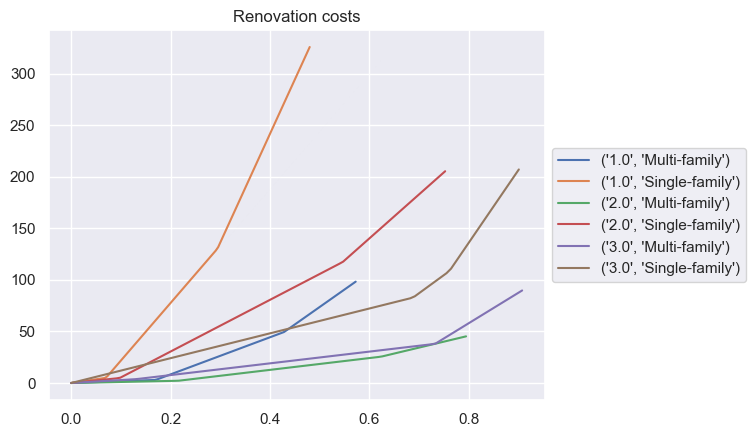

In [20]:
config = get_config(spec="greenfield")

LOG_FORMATTER = '%(asctime)s : %(name)s  : %(funcName)s : %(levelname)s : %(message)s'
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
# consoler handler
console_handler = logging.StreamHandler()
console_handler.setFormatter(logging.Formatter(LOG_FORMATTER))
logger.addHandler(console_handler)

hourly_profile_test = heating_hourly_profile(method="valentin", percentage=0)

# TODO: attention au choix de hourly profile !!
# ['Occupancy status', 'Income owner', 'Income tenant', 'Housing type', 'Heating system']
dict_cost, dict_heat = social_planner(aggregation_archetype=['Wall class', "Housing type"], climate=2006,
                                      smooth=False, building_stock="medium_3", hourly_profile=hourly_profile_test)
dict_heat = process_heating_need(dict_heat, climate=2006)

linearized_renovation_costs, threshold_linearized_renovation_costs = piecewise_linearization_cost_efficiency(
    dict_cost, number_of_segments=3, plot=True, plot_tot=True)

threshold_linearized_renovation_costs[
    threshold_linearized_renovation_costs < 0] = 0  # handles cases where the linearization was not perfect


In [21]:
# importing evolution of historical capacity
existing_capacity_historical, existing_charging_capacity_historical, existing_energy_capacity_historical,\
           maximum_capacity_evolution, heating_gas_demand_RTE_timesteps, ECS_gas_demand_RTE_timesteps, annuity_fOM_historical, storage_annuity_historical = load_evolution_data()

# TODO: il faudra ajouter les capacités pour charging et discharging
year = [2025, 2030, 2035, 2040, 2045, 2050]
trajectory_scc = [180, 250, 350, 500, 650, 776]  # from Quinet
# trajectory_scc = [100, 200, 300, 400, 500, 500]  # smaller CO2 cost

# Saving all new installed capacity
new_capacity_tot = pd.Series(0, index=existing_capacity_historical.index, dtype=float)
new_charging_capacity_tot = pd.Series(0, index=existing_charging_capacity_historical.index, dtype=float)
new_energy_capacity_tot = pd.Series(0, index=existing_energy_capacity_historical.index, dtype=float)

# Initialize renovation rate to 0 at first
existing_renovation_rate = pd.Series(0, index=linearized_renovation_costs.index, dtype=float)  # no renovation has been done

reindex_primary_prod = ["offshore_f", "offshore_g", "onshore", "pv_g", "pv_c", "river", "lake", "nuclear", "methanization", "pyrogazification", "natural_gas"]
reindex_heat_prod = ["resistive", "heat_pump", "gas_boiler", "fuel_boiler", "wood_boiler"]

capacity_df = pd.DataFrame(index=existing_capacity_historical.index, dtype=float)
new_capacity_df = pd.DataFrame(index=existing_capacity_historical.index, dtype=float)
generation_df = pd.DataFrame(index=existing_capacity_historical.index, dtype=float)
primary_generation_df = pd.DataFrame(index=reindex_primary_prod, dtype=float)
heat_generation_df = pd.DataFrame(index=reindex_heat_prod, dtype=float)
charging_capacity_df = pd.DataFrame(index=existing_charging_capacity_historical.index, dtype=float)
energy_capacity_df = pd.DataFrame(index=existing_energy_capacity_historical.index, dtype=float)
renovation_rate_df = pd.DataFrame(index=list(dict_heat.keys()), dtype=float)  # renovation rates per archetype

weighted_average_elec_price = pd.DataFrame(dtype=float)
weighted_average_CH4_price = pd.DataFrame(dtype=float)
weighted_average_H2_price = pd.DataFrame(dtype=float)
lcoe_elec = pd.DataFrame(dtype=float)
lcoe_elec_volume = pd.DataFrame(dtype=float)
lcoe_elec_value = pd.DataFrame(dtype=float)

annualized_costs_new_capacity, annualized_costs_new_energy_capacity = pd.DataFrame(0, index=existing_capacity_historical.index, columns=["annualized_costs"], dtype=float), \
                                              pd.DataFrame(0, index=existing_energy_capacity_historical.index, columns=["annualized_costs"], dtype=float)

dict_heat_modif = {key: dict_heat[key] * 1.1 for key in
                   dict_heat.keys()}  # TODO: permet de voir l'impact d'augmenter le besoin en chaleur

scenario_cost_high = {
    "capex": {
        "gas_boiler": 300,  # hypothesis Zeyen
        "fuel_boiler": 300,  # hypothesis Zeyen
        "wood_boiler": 300,  # hypothesis Zeyen
    } ,
    "fOM": {
        "gas_boiler": 21  # hypothesis Zeyen
    } ,
    "vOM": {
        "heat_pump": 0.002  # hypothesis Zeyen
    },
    "conversion_efficiency": {
        "gas_boiler": 0.75,
        # "methanation": 0.5  # trying a method similar to zeyen
    },
    "miscellaneous": {
        # "max_methanization": 100,
        # "max_pyrogazification": 50,
        "lifetime_renov": 40
    },
    "fix_capa": {
        "h2_ccgt": 0
    }
}

# config["biomass_potential"] = 'eoles/inputs/technology_potential/biomass_evolution_S2.csv'  # TODO: we try a different biomass potential !

In [20]:
m_scc.summary

weighted_price_demand        107.183890
weighted_price_generation     88.719120
elec_demand_tot              561.970000
hydrogen_demand_tot           50.000000
methane_demand_tot            46.000000
heat_demand_tot              211.220272
sumgene_elec                 727.785960
lcoe_elec                     55.451816
lcoe_elec_volume              59.554125
lcoe_CH4_volume              150.080946
lcoe_H2_volume                89.655821
lcoe_elec_value               65.032412
lcoe_CH4_value               122.894625
lcoe_H2_value                 53.094584
dtype: float64

## Run model

In [22]:
for y, scc in zip(year, trajectory_scc):
    print(f"Year {y}, SCC {scc}")

    #### Get existing and maximum capacities
    existing_capa_historical_y = existing_capacity_historical[[str(y)]].squeeze()  # get historical capacity still installed for year of interest
    existing_charging_capacity_historical_y = existing_charging_capacity_historical[[str(y)]].squeeze()
    existing_energy_capacity_historical_y = existing_energy_capacity_historical[[str(y)]].squeeze()

    new_maximum_capacity_y = maximum_capacity_evolution[[str(y)]].squeeze()  # get maximum new capacity to be built

    # Existing capacities at year y
    existing_capacity = existing_capa_historical_y + new_capacity_tot  # existing capacity are equal to newly built
    # capacities over the whole time horizon + existing capacity (from before 2020)
    existing_charging_capacity = existing_charging_capacity_historical_y + new_charging_capacity_tot
    existing_energy_capacity = existing_energy_capacity_historical_y + new_energy_capacity_tot

    # We reinitialize the heating vectors so that we can adapt at each time step the way to satisfy heating demand (ambitious hypothesis)
    existing_capacity[["heat_pump", "resistive", "gas_boiler", "wood_boiler", "fuel_boiler"]] = 0

    maximum_capacity = (existing_capacity + new_maximum_capacity_y).dropna()  # we drop nan values, which correspond to technologies without any upper bound

    #### Historical LCOE based on historical costs
    annualized_costs_capacity_historical, annualized_costs_energy_capacity_historical = annualized_costs_investment_historical(existing_capa_historical_y, annuity_fOM_historical,
                               existing_energy_capacity_historical_y, storage_annuity_historical)

    ### Compile total LCOE (based on historical + new)
    annualized_costs_capacity = pd.concat([annualized_costs_capacity_historical.rename(columns={'annualized_costs': 'historical_annualized_costs'}), annualized_costs_new_capacity], axis=1)
    annualized_costs_capacity['annualized_costs'] = annualized_costs_capacity['historical_annualized_costs'] + annualized_costs_capacity['annualized_costs']
    annualized_costs_energy_capacity = pd.concat([annualized_costs_energy_capacity_historical.rename(columns={'annualized_costs': 'historical_annualized_costs'}), annualized_costs_new_energy_capacity], axis=1)
    annualized_costs_energy_capacity['annualized_costs'] = annualized_costs_energy_capacity['historical_annualized_costs'] + annualized_costs_energy_capacity['annualized_costs']

    existing_annualized_costs_elec, existing_annualized_costs_CH4, existing_annualized_costs_H2 = process_annualized_costs_per_vector(annualized_costs_capacity[["annualized_costs"]].squeeze(), annualized_costs_energy_capacity[["annualized_costs"]].squeeze())
    print(existing_annualized_costs_elec, existing_annualized_costs_CH4)

    ### creating additional gas profile
    heating_gas_demand = heating_gas_demand_RTE_timesteps[y] * 1e3  # in TWh
    ECS_gas_demand = ECS_gas_demand_RTE_timesteps[y] * 1e3  # in TWh
    # ECS_gas_demand = ECS_gas_demand + 95*1e3  # we add transport + industry following scenario 3
    ECS_demand_hourly = ECS_gas_demand/8760
    hourly_gas = create_hourly_residential_demand_profile(total_consumption=heating_gas_demand,
                                                          method="valentin")  # value for gas heating demand in tertiary sector
    hourly_ECS = pd.Series(ECS_demand_hourly, index=hourly_gas.index)
    hourly_CH4_gas = hourly_gas + hourly_ECS

    m_scc = ModelEOLES(name="trajectory", config=config, path="eoles/outputs", logger=logger, nb_years=1,
                       heating_demand=dict_heat_modif, nb_linearize=3,
                       linearized_renovation_costs=linearized_renovation_costs,
                       threshold_linearized_renovation_costs=threshold_linearized_renovation_costs,
                       existing_capacity=existing_capacity, existing_charging_capacity=existing_charging_capacity,
                       existing_energy_capacity=existing_energy_capacity,
                       existing_renovation_rate=existing_renovation_rate, maximum_capacity=maximum_capacity,
                       social_cost_of_carbon=scc, year=y, scenario_cost=scenario_cost_high, hp_hourly=True,
                       renov=None, hourly_heat_gas=hourly_CH4_gas, existing_annualized_costs_elec=existing_annualized_costs_elec,
                       existing_annualized_costs_CH4=existing_annualized_costs_CH4, existing_annualized_costs_H2=existing_annualized_costs_H2)
    m_scc.build_model()
    solver_results, status, termination_condition = m_scc.solve(solver_name="gurobi")

    #### Update total capacities and new capacities
    new_capacity = m_scc.capacities - existing_capacity  # we get the newly installed capacities at year y
    new_charging_capacity = m_scc.charging_capacity - existing_charging_capacity
    new_energy_capacity = m_scc.energy_capacity - existing_energy_capacity
    gene_per_tec = pd.Series(m_scc.generation_per_technology)

    new_capacity_tot = new_capacity_tot + new_capacity  # total newly built capacity over the time horizon
    new_charging_capacity_tot = new_charging_capacity_tot + new_charging_capacity
    new_energy_capacity_tot = new_energy_capacity_tot + new_energy_capacity
    existing_renovation_rate = m_scc.renovation_rates_detailed  # we get new renovation decisions

    ##### Update existing LCOE to count all new capacities with corresponding costs !
    m_scc.new_capacity_annualized_costs[["heat_pump", "resistive", "gas_boiler", "wood_boiler", "fuel_boiler"]] = 0  # we do not want to count heating vectors here
    m_scc.new_energy_capacity_annualized_costs[["heat_pump", "resistive", "gas_boiler", "wood_boiler", "fuel_boiler"]] = 0  # we do not want to count heating vectors here

    annualized_costs_new_capacity = pd.concat([annualized_costs_new_capacity[["annualized_costs"]], m_scc.new_capacity_annualized_costs[["annualized_costs"]].rename(columns={'annualized_costs': 'new_annualized_costs'})], axis=1)
    annualized_costs_new_capacity["annualized_costs"] = annualized_costs_new_capacity["annualized_costs"] + annualized_costs_new_capacity['new_annualized_costs']
    annualized_costs_new_capacity = annualized_costs_new_capacity.drop(columns=['new_annualized_costs'])

    annualized_costs_new_energy_capacity = pd.concat([annualized_costs_new_energy_capacity[["annualized_costs"]], m_scc.new_energy_capacity_annualized_costs[["annualized_costs"]].rename(columns={'annualized_costs': 'new_annualized_costs'})],axis=1)
    annualized_costs_new_energy_capacity["annualized_costs"] = annualized_costs_new_energy_capacity["annualized_costs"] + annualized_costs_new_energy_capacity['new_annualized_costs']
    annualized_costs_new_energy_capacity = annualized_costs_new_energy_capacity.drop(columns=['new_annualized_costs'])

    capacity_df = pd.concat([capacity_df, m_scc.capacities.to_frame().rename(columns={0: y})], axis=1)
    charging_capacity_df = pd.concat([charging_capacity_df, m_scc.charging_capacity.to_frame().rename(columns={0: y})], axis=1)
    generation_df = pd.concat([generation_df, gene_per_tec.to_frame().rename(columns={0: y})], axis=1)
    energy_capacity_df = pd.concat([energy_capacity_df, m_scc.energy_capacity.to_frame().rename(columns={0: y})], axis=1)
    new_capacity_df = pd.concat([new_capacity_df, new_capacity.to_frame().rename(columns={0: y})], axis=1)
    renovation_rate_df = pd.concat([renovation_rate_df, m_scc.renovation_rates.to_frame().rename(columns={0: y})], axis=1)
    primary_generation_df = pd.concat([primary_generation_df, m_scc.primary_generation.reindex(reindex_primary_prod).to_frame().rename(columns={0: y})], axis=1)
    heat_generation_df = pd.concat([heat_generation_df, m_scc.heat_generation.reindex(reindex_heat_prod).to_frame().rename(columns={0: y})], axis=1)

    weighted_average_elec_price = pd.concat([weighted_average_elec_price, pd.Series(m_scc.summary["weighted_elec_price_demand"]).to_frame().rename(columns={0: y})], axis=1)
    weighted_average_CH4_price = pd.concat([weighted_average_CH4_price, pd.Series(m_scc.summary["weighted_CH4_price_demand"]).to_frame().rename(columns={0: y})], axis=1)
    lcoe_elec = pd.concat([lcoe_elec, pd.Series(m_scc.summary["lcoe_elec"]).to_frame().rename(columns={0: y})], axis=1)
    lcoe_elec_volume = pd.concat([lcoe_elec_volume, pd.Series(m_scc.summary["lcoe_elec_volume"]).to_frame().rename(columns={0: y})], axis=1)
    lcoe_elec_value = pd.concat([lcoe_elec_value, pd.Series(m_scc.summary["lcoe_elec_value"]).to_frame().rename(columns={0: y})], axis=1)


Year 2025, SCC 180
19934.2892 0.0


2022-12-23 16:56:49,123 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-12-23 16:56:49,123 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-12-23 16:57:14,469 : __main__  : solve : INFO : Optimization successful
2022-12-23 16:57:14,469 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:349: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:364: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (


22268.329465429426 10275.136951338041 320.70122138559356
Year 2030, SCC 250
19081.2892 0.0


2022-12-23 16:57:30,238 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-12-23 16:57:30,238 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-12-23 16:57:59,426 : __main__  : solve : INFO : Optimization successful
2022-12-23 16:57:59,426 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:349: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:364: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (


22308.31207440311 11548.377863580698 804.5748359847875
Year 2035, SCC 350
17848.5775132036 404.69949722748714


2022-12-23 16:58:14,998 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-12-23 16:58:14,998 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-12-23 16:58:46,013 : __main__  : solve : INFO : Optimization successful
2022-12-23 16:58:46,013 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:349: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:364: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (


23575.42169285094 12503.998614141465 941.3369415811495
Year 2040, SCC 500
18410.85377659882 1070.0568024143913


2022-12-23 16:59:01,572 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-12-23 16:59:01,572 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-12-23 16:59:36,117 : __main__  : solve : INFO : Optimization successful
2022-12-23 16:59:36,117 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:349: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:364: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (


27226.52758985137 11981.59580582507 1002.3548572315959
Year 2045, SCC 650
21956.019602001677 1922.345825365161


2022-12-23 16:59:51,586 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-12-23 16:59:51,586 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-12-23 17:00:28,263 : __main__  : solve : INFO : Optimization successful
2022-12-23 17:00:28,263 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:349: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:364: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (


29570.08970239056 7713.689863421599 1192.0666201712845
Year 2050, SCC 776
22354.414325936785 3477.0329785783842


2022-12-23 17:00:44,424 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-12-23 17:00:44,424 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-12-23 17:01:15,149 : __main__  : solve : INFO : Optimization successful
2022-12-23 17:01:15,149 : __main__  : solve : INFO : Optimization successful


31303.602970859985 11737.191693373828 2251.756263200508


/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:364: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (


In [67]:
m_scc.summary

weighted_elec_price_demand    127.980542
weighted_CH4_price_demand     184.077411
weighted_H2_price_demand       42.063382
weighted_price_generation     106.066607
elec_demand_tot               561.970000
hydrogen_demand_tot            50.000000
methane_demand_tot             46.000000
heat_demand_tot               211.220272
sumgene_elec                  716.904516
lcoe_elec                      59.699744
lcoe_elec_volume               48.757820
lcoe_CH4_volume                22.764211
lcoe_H2_volume                 79.687327
lcoe_elec_value                66.914309
lcoe_CH4_value                171.548147
lcoe_H2_value                  36.162586
dtype: float64

## Plots

### Demand and spot price

In [15]:
m_scc.spot_price.loc[m_scc.spot_price.spot_price < 20]

hour  spot_price
1115  1115         6.0
1116  1116         6.0
1135  1135         6.0
1136  1136         6.0
1137  1137         6.0
...    ...         ...
8724  8724         6.0
8725  8725         6.0
8726  8726         6.0
8747  8747         6.0
8748  8748         6.0

[1440 rows x 2 columns]

In [24]:
m_scc.spot_price.describe()

hour    spot_price
count  8760.000000   8760.000000
mean   4379.500000     99.060671
std    2528.938512    527.591090
min       0.000000     -0.000000
25%    2189.750000     45.360208
50%    4379.500000     49.862930
75%    6569.250000    154.569971
max    8759.000000  48494.316704

In [8]:
RTEdemand = get_pandas( "eoles/inputs/demand/demand2050_RTE.csv", lambda x: pd.read_csv(x, index_col=0, header=None).squeeze("columns"))  # GW
RTEdemand = RTEdemand.reset_index().rename(columns={0: "hour", 1: "RTE_demand"})

tmp = m_scc.hourly_generation
climate = 2006
tmp["date"] = tmp.apply(lambda row: datetime.datetime(climate, 1, 1, 0) + datetime.timedelta(hours=row["hour"]), axis=1)
tmp = tmp.merge(m_scc.spot_price, on="hour")
tmp = tmp.merge(RTEdemand, on="hour")


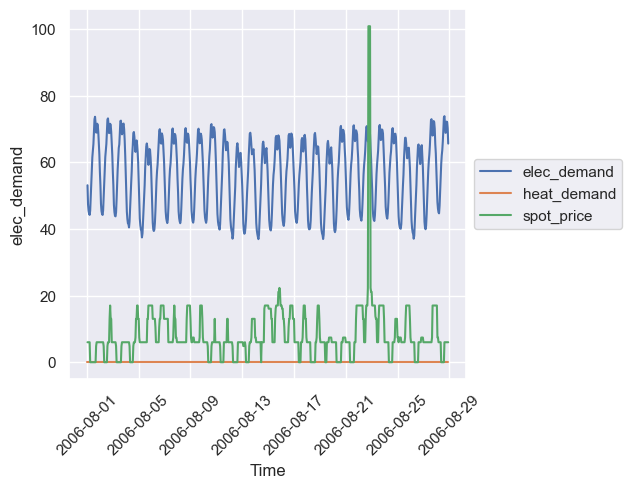

In [16]:
date_start, date_end = datetime.datetime(climate, 8, 1, 0), datetime.datetime(climate, 8, 28, 23)

fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(tmp.loc[(tmp.date > date_start) & (tmp.date < date_end)], x="date", y="elec_demand", label="elec_demand")
# sns.lineplot(tmp.loc[(tmp.date > date_start) & (tmp.date < date_end)], x="date", y="RTE_demand", label="RTE_demand")
sns.lineplot(tmp.loc[(tmp.date > date_start) & (tmp.date < date_end)], x="date", y="heat_demand", label="heat_demand")
sns.lineplot(tmp.loc[(tmp.date > date_start) & (tmp.date < date_end)], x="date", y="spot_price", label="spot_price")
ax.set_xlabel("Time")
# ax.set_ylim(0,400)
# ax.set_ylim(0,10)
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.set_facecolor('xkcd:white')
plt.xticks(rotation = 45)
plt.show()

In [33]:
tmp.loc[tmp.spot_price > 1000]

hour demand  offshore_f  offshore_g   onshore  pv_g  pv_c     river  \
763    763    NaN    2.019514    0.761143  4.499296   0.0   0.0  4.752527   
8636  8636    NaN    1.028769    2.094857  4.179637   0.0   0.0  1.781076   

           lake  methanization  ...  battery1_charge  battery4_charge  \
763   12.855000      47.631971  ...              0.0        19.515093   
8636   6.301074      47.631971  ...              0.0        14.052540   

      hydrogen_charge  methane_charge  elec_demand  CH4_demand  H2_demand  \
763       3262.304363     1334.880932    87.718473    9.649661   5.707763   
8636      7090.973012     2019.885731    80.691930   10.574890   5.707763   

      heat_demand                date    spot_price  
763     75.951596 2006-02-01 19:00:00  48492.777696  
8636    85.693723 2006-12-26 20:00:00   5413.013934  

[2 rows x 44 columns]

<AxesSubplot:xlabel='hour', ylabel='spot_price'>

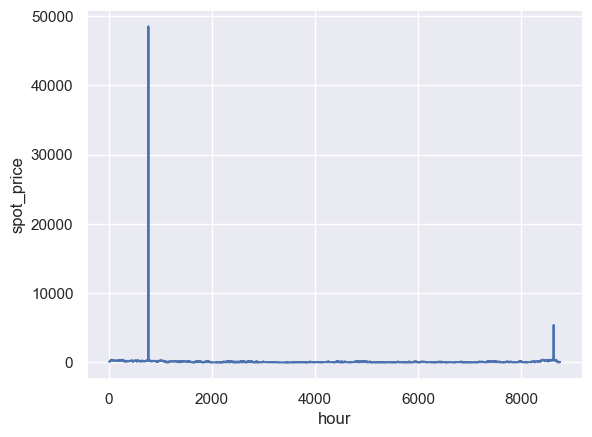

In [28]:
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(m_scc.spot_price, x="hour", y="spot_price")


### LCOE

Text(0, 0.5, 'LCOE and average elec price (€/MWh)')

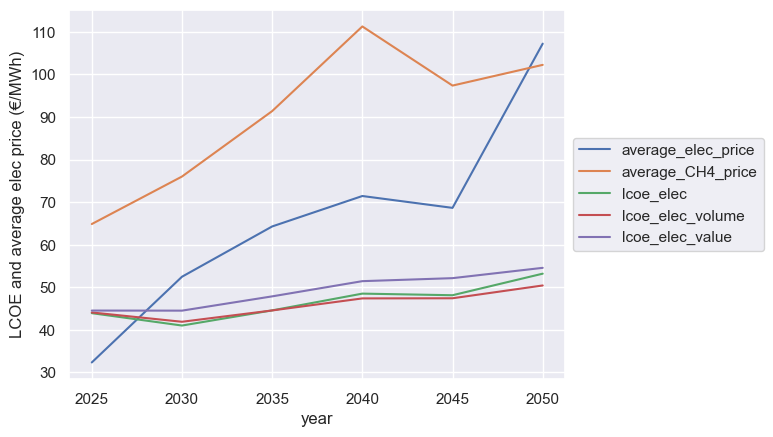

In [5]:
lcoe_df = pd.concat([weighted_average_elec_price.rename(index={0 : "average_elec_price"}), lcoe_elec.rename(index={0 : "lcoe_elec"}),
                     lcoe_elec_volume.rename(index={0 : "lcoe_elec_volume"}), lcoe_elec_value.rename(index={0 : "lcoe_elec_value"}),
                     weighted_average_CH4_price.rename(index={0 : "average_CH4_price"})], axis=0)
lcoe_df = lcoe_df.T.reset_index().rename(columns={"index": "year"})

fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(lcoe_df, x="year", y="average_elec_price", label="average_elec_price")
sns.lineplot(lcoe_df, x="year", y="average_CH4_price", label="average_CH4_price")
sns.lineplot(lcoe_df, x="year", y="lcoe_elec", label="lcoe_elec")
sns.lineplot(lcoe_df, x="year", y="lcoe_elec_volume", label="lcoe_elec_volume")
sns.lineplot(lcoe_df, x="year", y="lcoe_elec_value", label="lcoe_elec_value")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel("LCOE and average elec price (€/MWh)")

Text(0, 0.5, 'LCOE and average elec price (€/MWh)')

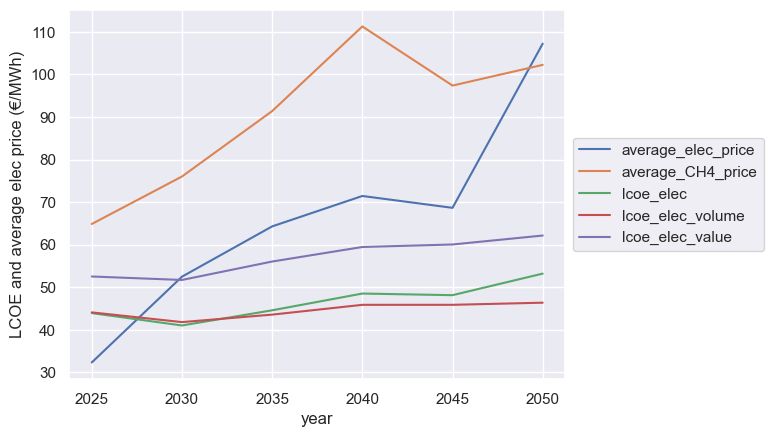

In [56]:
lcoe_df = pd.concat([weighted_average_elec_price.rename(index={0 : "average_elec_price"}), lcoe_elec.rename(index={0 : "lcoe_elec"}),
                     lcoe_elec_volume.rename(index={0 : "lcoe_elec_volume"}), lcoe_elec_value.rename(index={0 : "lcoe_elec_value"}),
                     weighted_average_CH4_price.rename(index={0 : "average_CH4_price"})], axis=0)
lcoe_df = lcoe_df.T.reset_index().rename(columns={"index": "year"})

fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(lcoe_df, x="year", y="average_elec_price", label="average_elec_price")
sns.lineplot(lcoe_df, x="year", y="average_CH4_price", label="average_CH4_price")
sns.lineplot(lcoe_df, x="year", y="lcoe_elec", label="lcoe_elec")
sns.lineplot(lcoe_df, x="year", y="lcoe_elec_volume", label="lcoe_elec_volume")
sns.lineplot(lcoe_df, x="year", y="lcoe_elec_value", label="lcoe_elec_value")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel("LCOE and average elec price (€/MWh)")

In [9]:
weighted_average_elec_price

2025       2030       2035       2040       2045        2050
0  32.312426  52.462831  64.284441  71.437075  68.648821  107.249142

In [25]:
weighted_average_elec_price

2025       2030       2035       2040       2045        2050
0  32.315166  52.462831  64.285753  71.437075  68.648821  107.247677

In [36]:
weighted_average_elec_price

2025       2030       2035       2040       2045        2050
0  32.316829  51.406017  63.512204  69.340905  67.524199  107.184146

In [10]:
lcoe_elec

2025       2030       2035      2040       2045     2050
0  43.899514  40.991523  44.577011  48.49658  48.115727  53.1836

In [37]:
lcoe_elec

2025        2030       2035       2040       2045       2050
0  115.42336  100.875252  64.889981  61.581021  55.965302  55.451846

In [8]:
lcoe_elec_volume

2025       2030       2035       2040       2045       2050
0  44.065993  41.782419  43.541163  45.844413  45.847486  46.346947

In [11]:
lcoe_elec_volume

2025       2030       2035       2040       2045       2050
0  51.910221  48.251569  51.628011  54.140444  53.866798  56.907671

In [38]:
lcoe_elec_volume

2025        2030       2035       2040      2045       2050
0  136.491956  119.098877  75.746361  69.781833  63.13412  59.554105

In [12]:
lcoe_elec_value

2025       2030       2035       2040       2045       2050
0  52.507205  51.689722  56.056466  59.445032  60.031786  62.135724

In [39]:
lcoe_elec_value

2025        2030       2035       2040       2045       2050
0  138.061775  127.560128  82.198164  76.583898  70.297876  65.032375

### Capacity

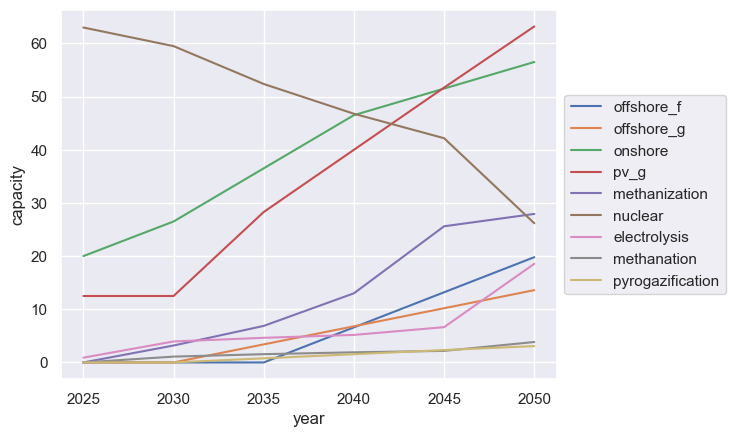

In [23]:
tmp = capacity_df.transpose().stack().reset_index().rename(columns={'level_0': 'year', 'level_1': 'technology', 0: 'capacity'})
tmp = tmp.loc[tmp.technology.isin(["offshore_f", "offshore_g", "onshore", "pv_g", "methanization", "nuclear", "electrolysis", "methanation", "pyrogazification"])]
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(tmp, x="year", y="capacity", hue="technology")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

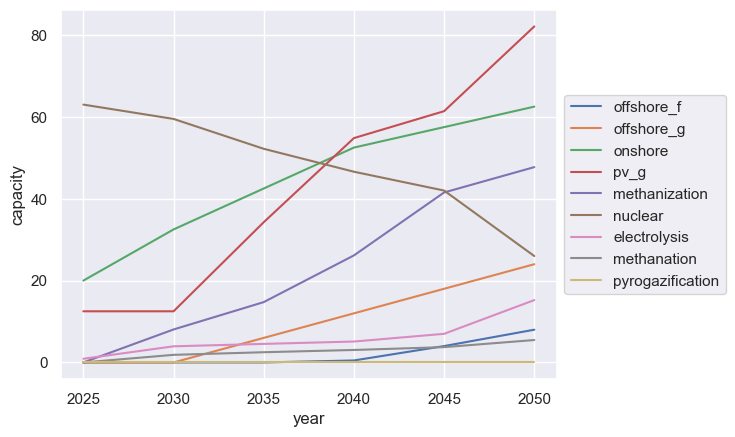

In [14]:
tmp = capacity_df.transpose().stack().reset_index().rename(columns={'level_0': 'year', 'level_1': 'technology', 0: 'capacity'})
tmp = tmp.loc[tmp.technology.isin(["offshore_f", "offshore_g", "onshore", "pv_g", "methanization", "nuclear", "electrolysis", "methanation", "pyrogazification"])]
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(tmp, x="year", y="capacity", hue="technology")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

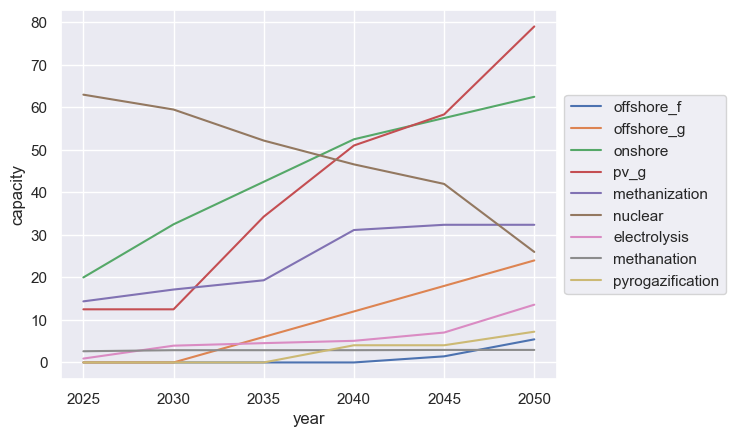

In [5]:
tmp = capacity_df.transpose().stack().reset_index().rename(columns={'level_0': 'year', 'level_1': 'technology', 0: 'capacity'})
tmp = tmp.loc[tmp.technology.isin(["offshore_f", "offshore_g", "onshore", "pv_g", "methanization", "nuclear", "electrolysis", "methanation", "pyrogazification"])]
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(tmp, x="year", y="capacity", hue="technology")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

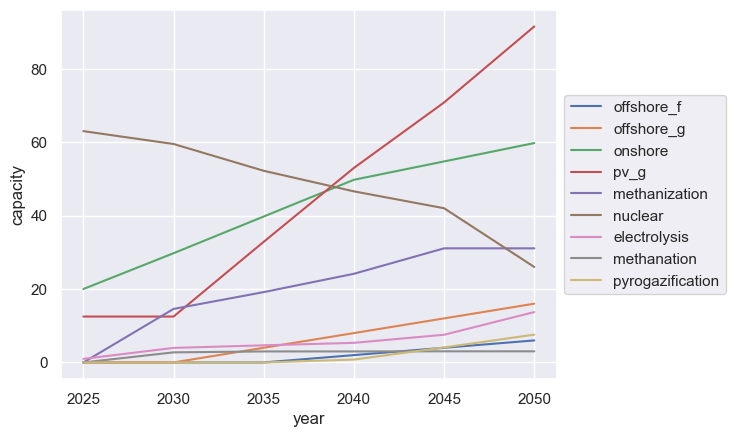

In [37]:
tmp = capacity_df.transpose().stack().reset_index().rename(columns={'level_0': 'year', 'level_1': 'technology', 0: 'capacity'})
tmp = tmp.loc[tmp.technology.isin(["offshore_f", "offshore_g", "onshore", "pv_g", "methanization", "nuclear", "electrolysis", "methanation", "pyrogazification"])]
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(tmp, x="year", y="capacity", hue="technology")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

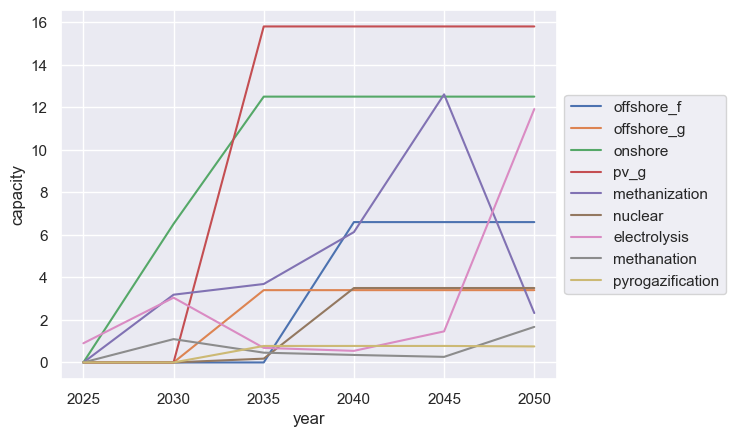

In [24]:
tmp = new_capacity_df.transpose().stack().reset_index().rename(columns={'level_0': 'year', 'level_1': 'technology', 0: 'capacity'})
tmp = tmp.loc[tmp.technology.isin(["offshore_f", "offshore_g", "onshore", "pv_g", "methanization", "nuclear", "electrolysis", "methanation", "pyrogazification"])]
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(tmp, x="year", y="capacity", hue="technology")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

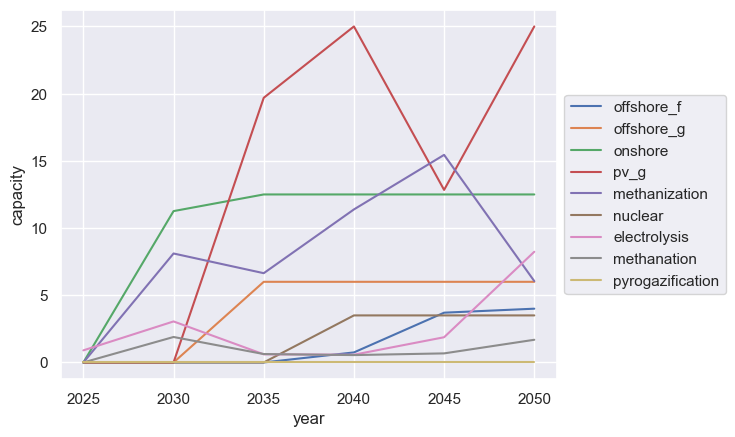

In [22]:
tmp = new_capacity_df.transpose().stack().reset_index().rename(columns={'level_0': 'year', 'level_1': 'technology', 0: 'capacity'})
tmp = tmp.loc[tmp.technology.isin(["offshore_f", "offshore_g", "onshore", "pv_g", "methanization", "nuclear", "electrolysis", "methanation", "pyrogazification"])]
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(tmp, x="year", y="capacity", hue="technology")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

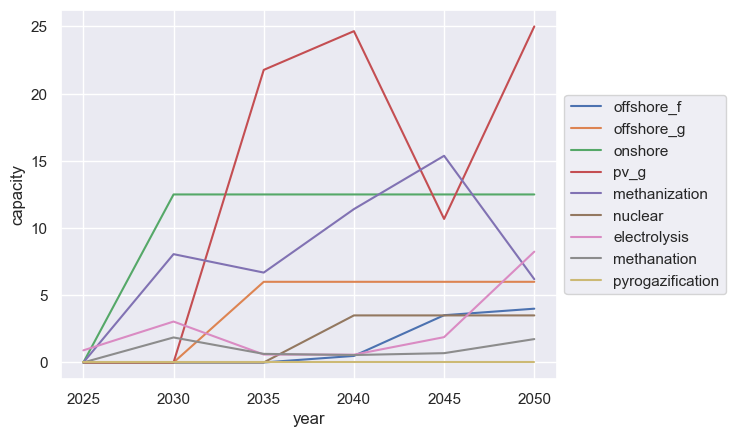

In [17]:
tmp = new_capacity_df.transpose().stack().reset_index().rename(columns={'level_0': 'year', 'level_1': 'technology', 0: 'capacity'})
tmp = tmp.loc[tmp.technology.isin(["offshore_f", "offshore_g", "onshore", "pv_g", "methanization", "nuclear", "electrolysis", "methanation", "pyrogazification"])]
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(tmp, x="year", y="capacity", hue="technology")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

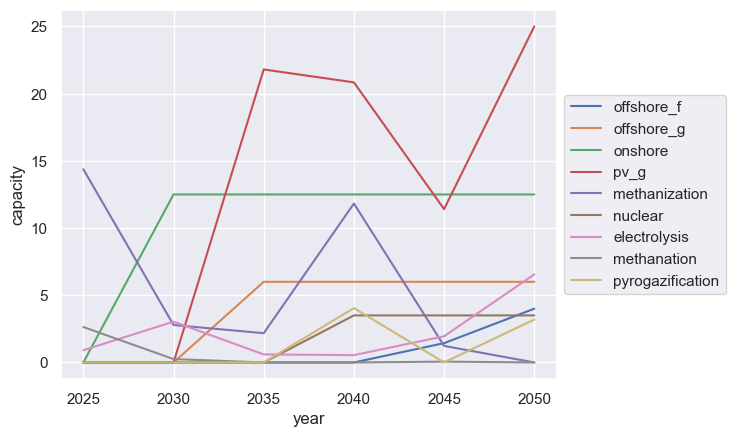

In [6]:
tmp = new_capacity_df.transpose().stack().reset_index().rename(columns={'level_0': 'year', 'level_1': 'technology', 0: 'capacity'})
tmp = tmp.loc[tmp.technology.isin(["offshore_f", "offshore_g", "onshore", "pv_g", "methanization", "nuclear", "electrolysis", "methanation", "pyrogazification"])]
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(tmp, x="year", y="capacity", hue="technology")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

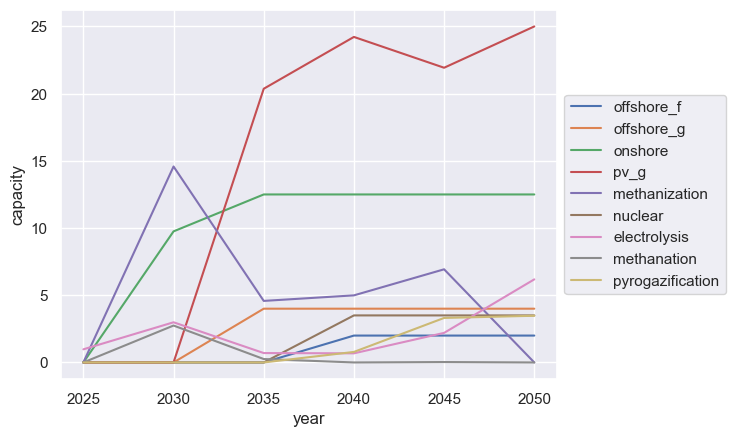

In [36]:
tmp = new_capacity_df.transpose().stack().reset_index().rename(columns={'level_0': 'year', 'level_1': 'technology', 0: 'capacity'})
tmp = tmp.loc[tmp.technology.isin(["offshore_f", "offshore_g", "onshore", "pv_g", "methanization", "nuclear", "electrolysis", "methanation", "pyrogazification"])]
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(tmp, x="year", y="capacity", hue="technology")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

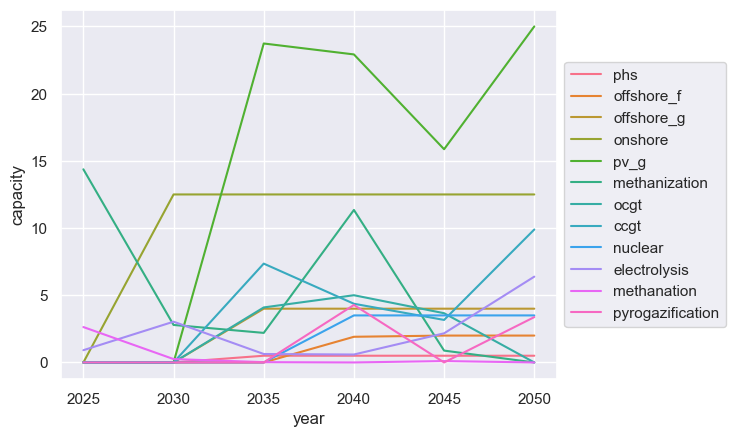

In [19]:
tmp = new_capacity_df.transpose().stack().reset_index().rename(columns={'level_0': 'year', 'level_1': 'technology', 0: 'capacity'})
tmp = tmp.loc[tmp.technology.isin(["phs", "offshore_f", "offshore_g", "onshore", "pv_g", "methanization", "ocgt", "ccgt", "nuclear", "electrolysis", "methanation", "pyrogazification"])]
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(tmp, x="year", y="capacity", hue="technology")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Renovation

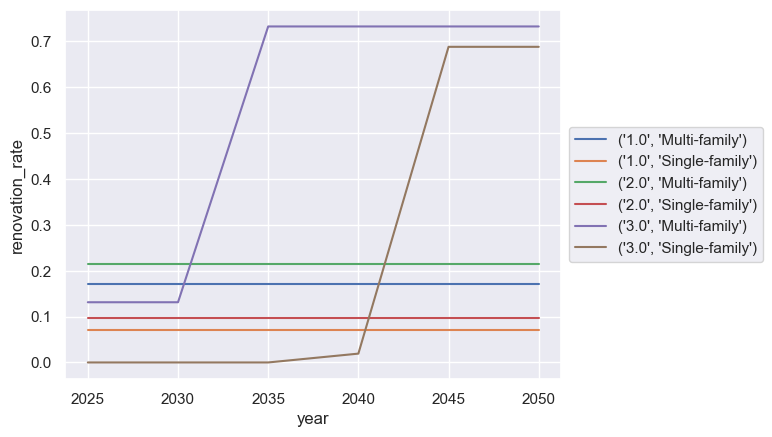

In [25]:
tmp = renovation_rate_df.transpose().stack().reset_index().rename(columns={'level_0': 'year', 'level_1': 'archetype', 0: 'renovation_rate'})
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(tmp, x="year", y="renovation_rate", hue="archetype")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

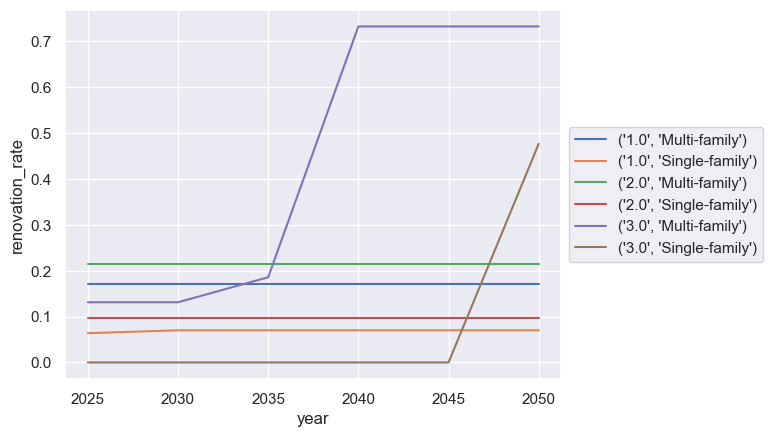

In [6]:
tmp = renovation_rate_df.transpose().stack().reset_index().rename(columns={'level_0': 'year', 'level_1': 'archetype', 0: 'renovation_rate'})
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(tmp, x="year", y="renovation_rate", hue="archetype")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

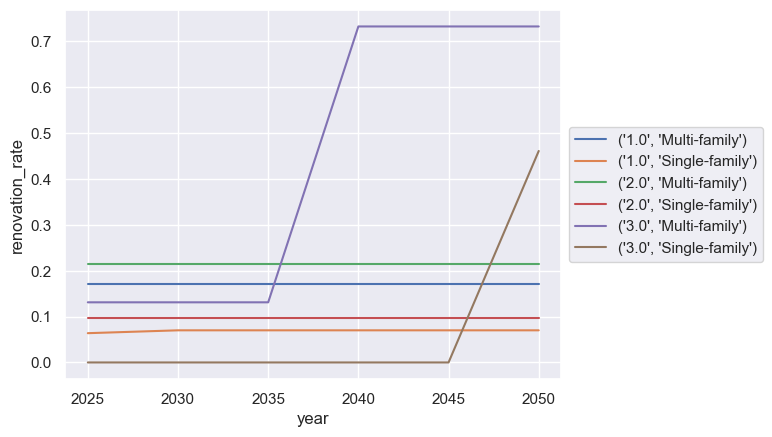

In [18]:
tmp = renovation_rate_df.transpose().stack().reset_index().rename(columns={'level_0': 'year', 'level_1': 'archetype', 0: 'renovation_rate'})
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(tmp, x="year", y="renovation_rate", hue="archetype")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

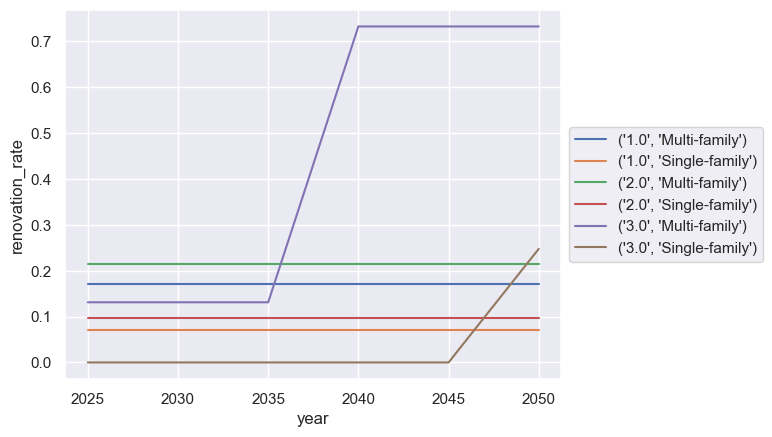

In [7]:
tmp = renovation_rate_df.transpose().stack().reset_index().rename(columns={'level_0': 'year', 'level_1': 'archetype', 0: 'renovation_rate'})
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(tmp, x="year", y="renovation_rate", hue="archetype")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

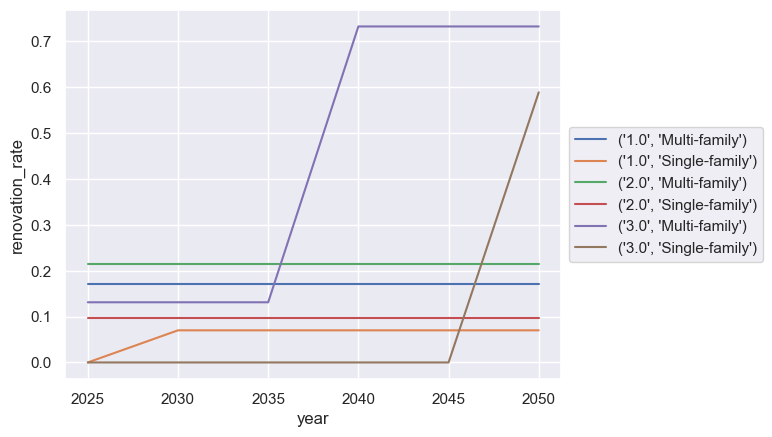

In [30]:
tmp = renovation_rate_df.transpose().stack().reset_index().rename(columns={'level_0': 'year', 'level_1': 'archetype', 0: 'renovation_rate'})
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(tmp, x="year", y="renovation_rate", hue="archetype")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

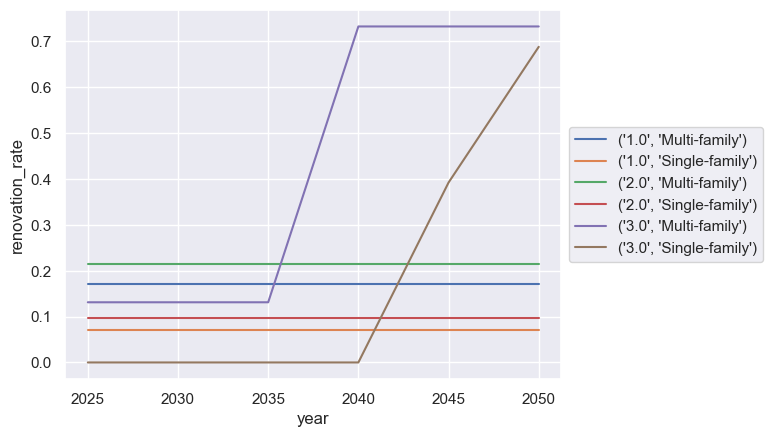

In [27]:
tmp = renovation_rate_df.transpose().stack().reset_index().rename(columns={'level_0': 'year', 'level_1': 'archetype', 0: 'renovation_rate'})
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(tmp, x="year", y="renovation_rate", hue="archetype")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

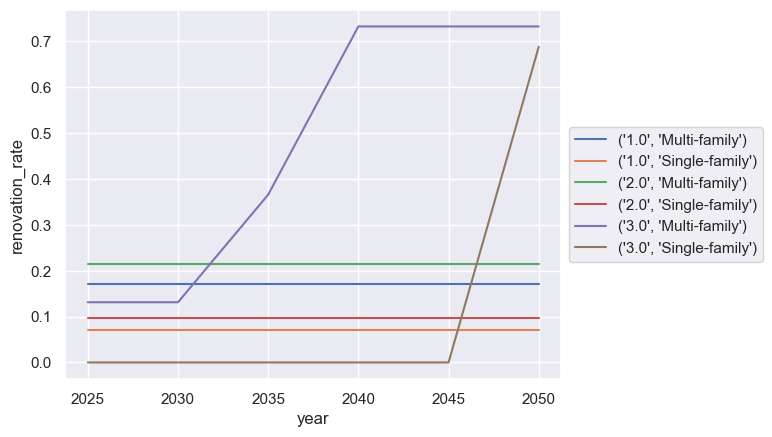

In [20]:
tmp = renovation_rate_df.transpose().stack().reset_index().rename(columns={'level_0': 'year', 'level_1': 'archetype', 0: 'renovation_rate'})
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(tmp, x="year", y="renovation_rate", hue="archetype")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Production

<Figure size 640x480 with 0 Axes>

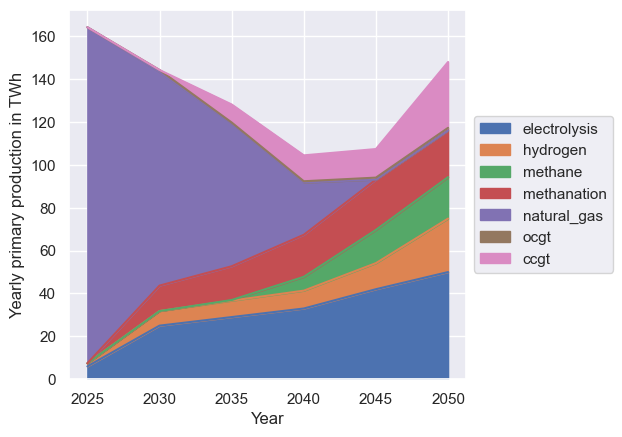

In [7]:
fig = plt.figure()
ax = generation_df.T[["electrolysis", "hydrogen", "methane", "methanation", "natural_gas", "ocgt", "ccgt"]].plot.area()
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Year")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

<Figure size 640x480 with 0 Axes>

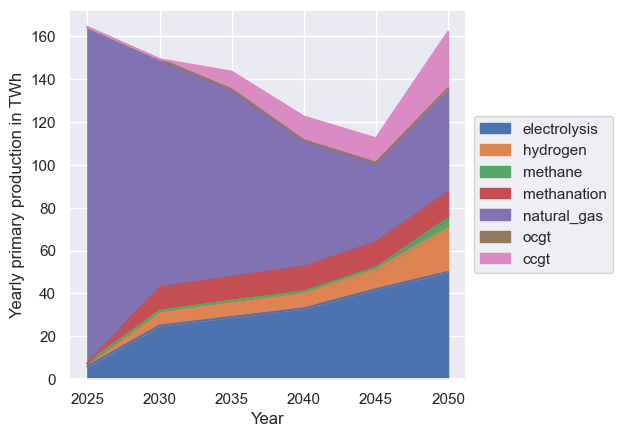

In [64]:
fig = plt.figure()
ax = generation_df.T[["electrolysis", "hydrogen", "methane", "methanation", "natural_gas", "ocgt", "ccgt"]].plot.area()
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Year")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

<Figure size 640x480 with 0 Axes>

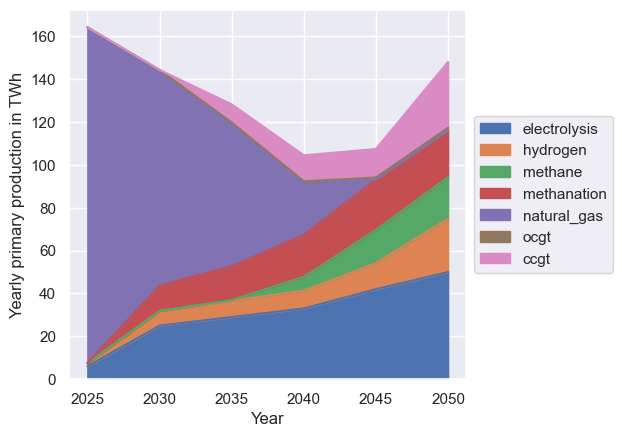

In [36]:
fig = plt.figure()
ax = generation_df.T[["electrolysis", "hydrogen", "methane", "methanation", "natural_gas", "ocgt", "ccgt"]].plot.area()
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Year")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [39]:
primary_generation_df

2025        2030        2035        2040        2045  \
offshore_f          0.000000    0.000000    0.000000    3.480261   20.740937   
offshore_g          0.000000    0.000000   27.615879   55.231759   82.847638   
onshore            56.889089   88.919510  117.364055  145.808599  160.030872   
pv_g               17.774951   17.774951   45.776759   75.496477   87.921642   
pv_c                0.000000    0.000000    0.000000    0.000000    0.000000   
river              28.482600   28.482600   28.482600   28.482600   28.482600   
lake               15.302186   15.302186   15.302186   15.302186   15.302186   
nuclear           388.838417  415.397505  361.673691  310.570444  290.873393   
methanization       0.000000   46.000000   61.000000   76.000000   91.000000   
pyrogazification    0.000000    0.000000    0.000000    0.000000    0.000000   
natural_gas       156.678926   99.591005   66.649412   24.353368    0.000000   

                        2050  
offshore_f         39.384885  
offshore_g        110.463518  
onshore           174.253144  
pv_g              117.356961  
pv_c                0.000000  
river              28.482600  
lake               15.302186  
nuclear           209.829975  
methanization     106.000000  
pyrogazification    0.000000  
natural_gas         0.000000

<Figure size 640x480 with 0 Axes>

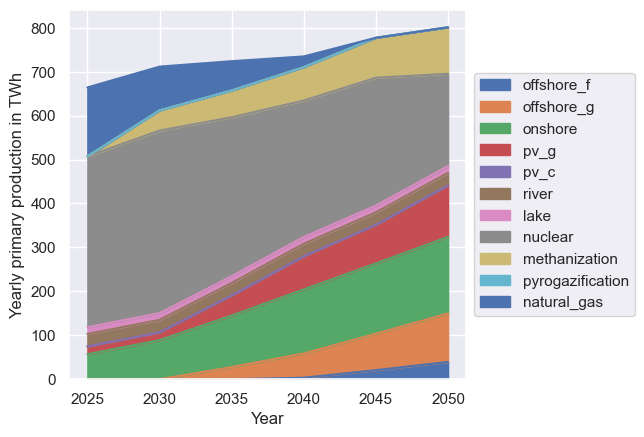

In [11]:
fig = plt.figure()
ax = primary_generation_df.T.plot.area()
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Year")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

<Figure size 640x480 with 0 Axes>

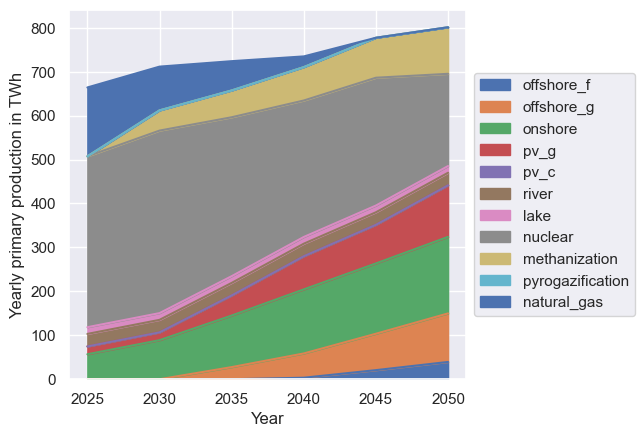

In [23]:
fig = plt.figure()
ax = primary_generation_df.T.plot.area()
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Year")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

<Figure size 640x480 with 0 Axes>

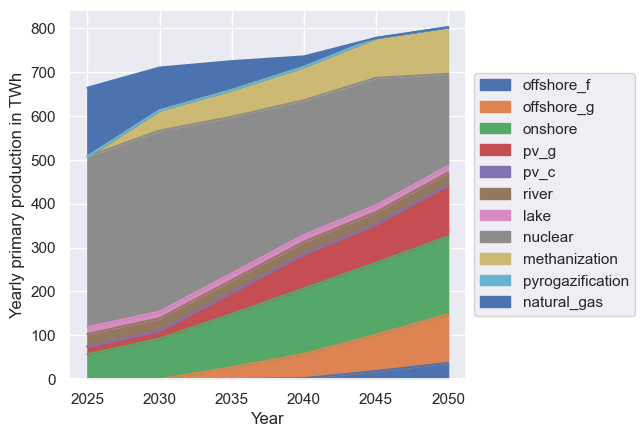

In [16]:
fig = plt.figure()
ax = primary_generation_df.T.plot.area()
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Year")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

<Figure size 640x480 with 0 Axes>

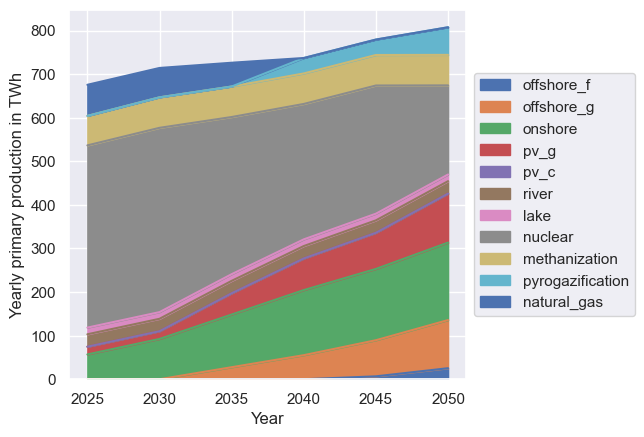

In [8]:
fig = plt.figure()
ax = primary_generation_df.T.plot.area()
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Year")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

<Figure size 640x480 with 0 Axes>

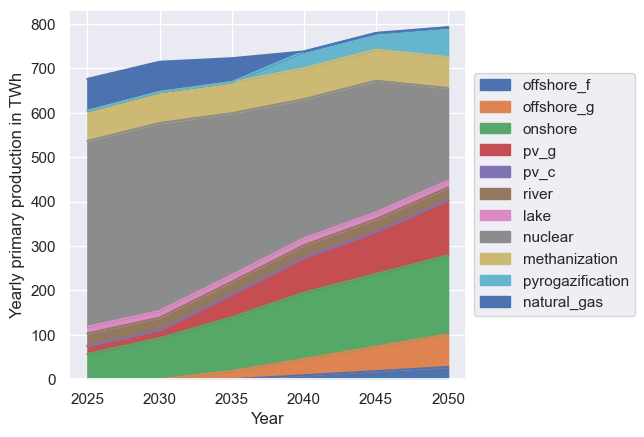

In [21]:
fig = plt.figure()
ax = primary_generation_df.T.plot.area()
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Year")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Heat production

<Figure size 640x480 with 0 Axes>

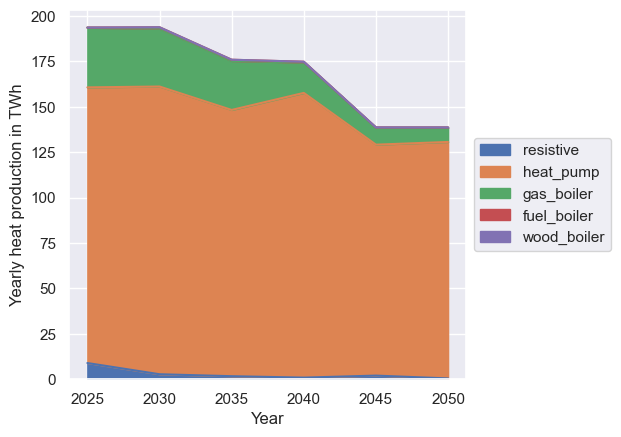

In [26]:
fig = plt.figure()
ax = heat_generation_df.T.plot.area()
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Year")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

<Figure size 640x480 with 0 Axes>

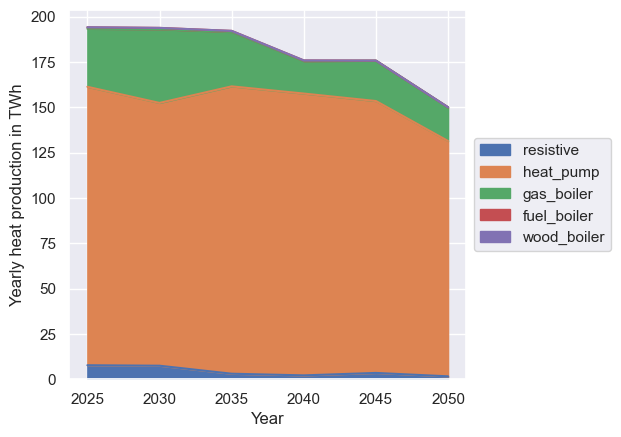

In [8]:
fig = plt.figure()
ax = heat_generation_df.T.plot.area()
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Year")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

<Figure size 640x480 with 0 Axes>

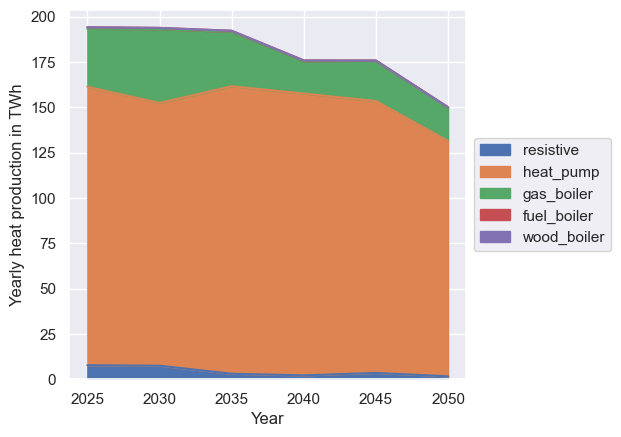

In [7]:
fig = plt.figure()
ax = heat_generation_df.T.plot.area()
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Year")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

<Figure size 640x480 with 0 Axes>

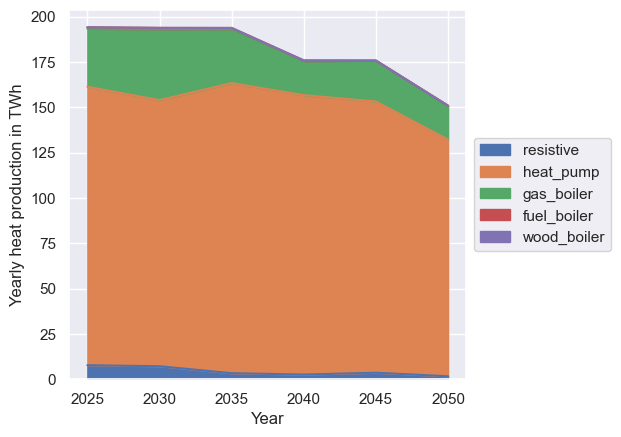

In [15]:
fig = plt.figure()
ax = heat_generation_df.T.plot.area()
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Year")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

<Figure size 640x480 with 0 Axes>

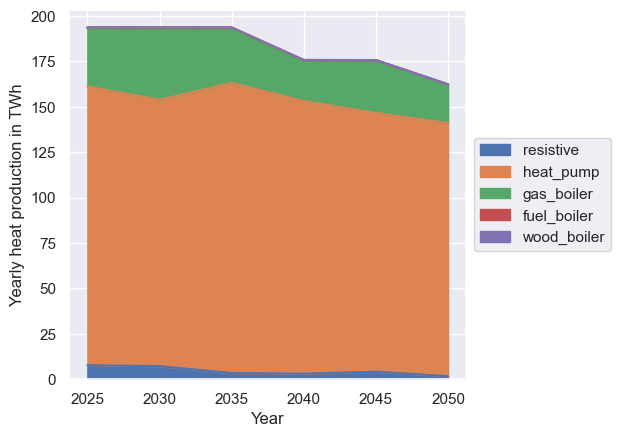

In [10]:
fig = plt.figure()
ax = heat_generation_df.T.plot.area()
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Year")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

<Figure size 640x480 with 0 Axes>

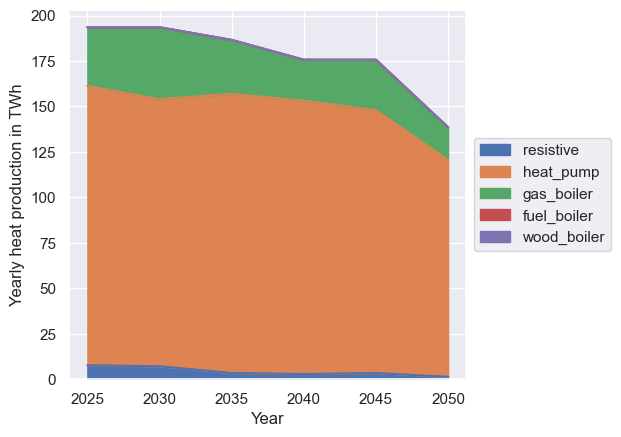

In [22]:
fig = plt.figure()
ax = heat_generation_df.T.plot.area()
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Year")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [35]:
generation_df

2025        2030        2035        2040        2045  \
river              28.482600   28.482600   28.482600   28.482600   28.482600   
lake               15.302186   15.302186   15.302186   15.302186   15.302186   
phs                 2.694056    3.604021    4.758190    7.578768   12.159922   
offshore_f          0.000000    0.000000    0.000000    8.902561   18.224535   
offshore_g          0.000000    0.000000   18.410586   36.821173   55.231759   
onshore            56.889089   92.444770  120.889314  149.333858  163.556131   
onshore_V110             NaN         NaN         NaN         NaN         NaN   
pv_g               17.774951   17.774951   51.494140   78.281685   95.010694   
pv_g_ns                  NaN         NaN         NaN         NaN         NaN   
pv_c                0.000000    0.000000    0.000000    0.000000    0.000000   
methanization      67.673148   70.000000   70.000000   70.000000   70.000000   
ocgt                0.035371    0.998864    0.389250    0.637002    0.853914   
ccgt                0.000000    0.000000    7.829018   11.659939   15.506530   
nuclear           418.068831  422.785976  364.335778  313.460246  296.329720   
h2_ccgt             0.000000    0.000000    0.000000    0.000000    0.000000   
battery1            0.000000    0.000000    0.000000    0.000000    0.000000   
battery4            0.000000    0.000000    0.000000    0.000000    0.000000   
electrolysis        6.000000   25.000000   29.000000   33.000000   42.000000   
hydrogen            1.492851    6.693079    7.659645    8.568585   12.953095   
methane             0.402076    0.367908    1.230237   22.919896   27.477548   
methanation        17.459672   18.060000   18.060000   18.060000   18.060000   
pyrogazification    0.000000    0.000000    0.000000   37.466309   37.466309   
natural_gas        71.988199   68.005588   53.752465    0.000000    0.000000   
heat_pump         153.602760  146.833879  153.329949  150.304994  144.552480   
resistive           7.689551    7.157071    3.447122    2.842819    3.413266   
gas_boiler         32.274444   39.576321   29.628165   22.558328   27.740315   
fuel_boiler         0.000000    0.000000    0.000000    0.000000    0.000000   
wood_boiler         0.001227    0.000619    0.000950    0.001182    0.001276   

                        2050  
river              28.482600  
lake               15.302186  
phs                14.898726  
offshore_f         27.546509  
offshore_g         73.642345  
onshore           177.778403  
onshore_V110             NaN  
pv_g              124.446012  
pv_g_ns                  NaN  
pv_c                0.000000  
methanization      70.000000  
ocgt                1.307703  
ccgt               39.765921  
nuclear           208.346560  
h2_ccgt             0.000000  
battery1            0.000000  
battery4            8.492775  
electrolysis       50.000000  
hydrogen           24.929224  
methane            37.296169  
methanation         6.010247  
pyrogazification   67.018545  
natural_gas         0.000000  
heat_pump         119.233049  
resistive           1.337075  
gas_boiler         17.996070  
fuel_boiler         0.000000  
wood_boiler         0.000000

In [34]:
renovation_rates_df

2025      2030      2035      2040      2045  \
(1.0, Multi-family)   0.169990  0.169990  0.169990  0.169990  0.169990   
(1.0, Single-family)  0.070004  0.070004  0.070004  0.070004  0.070004   
(2.0, Multi-family)   0.215392  0.215392  0.215392  0.215392  0.215392   
(2.0, Single-family)  0.097347  0.097347  0.097347  0.097347  0.097347   
(3.0, Multi-family)   0.131056  0.131056  0.372039  0.732042  0.732042   
(3.0, Single-family)  0.000000  0.000000  0.000000  0.000000  0.000000   

                          2050  
(1.0, Multi-family)   0.169990  
(1.0, Single-family)  0.070004  
(2.0, Multi-family)   0.215392  
(2.0, Single-family)  0.097347  
(3.0, Multi-family)   0.732042  
(3.0, Single-family)  0.687661

In [25]:
renovation_rates_df

2025      2030      2035      2040      2045  \
(1.0, Multi-family)   0.169990  0.169990  0.169990  0.169990  0.169990   
(1.0, Single-family)  0.070004  0.070004  0.070004  0.070004  0.070004   
(2.0, Multi-family)   0.215392  0.215392  0.215392  0.215392  0.215392   
(2.0, Single-family)  0.097347  0.097347  0.097347  0.097347  0.097347   
(3.0, Multi-family)   0.131056  0.131056  0.131056  0.732042  0.732042   
(3.0, Single-family)  0.000000  0.000000  0.000000  0.000000  0.051853   

                          2050  
(1.0, Multi-family)   0.169990  
(1.0, Single-family)  0.070004  
(2.0, Multi-family)   0.215392  
(2.0, Single-family)  0.097347  
(3.0, Multi-family)   0.732042  
(3.0, Single-family)  0.687661